In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install deap

     |████████████████████████████████| 163kB 2.7MB/s 


In [3]:
!pip install bitstring

     |████████████████████████████████| 204kB 2.8MB/s 
  Created wheel for bitstring: filename=bitstring-3.1.7-cp36-none-any.whl size=37948 sha256=658248c1b8948b6bfdbcc09d45a95e4372cbd9b6a15768b7a1b4ced2c90c1a6a
  Stored in directory: /root/.cache/pip/wheels/b8/27/f0/8373e26b7de57db03dc18aaaebdd8c26a99da882416f762979
Successfully built bitstring


In [4]:
!pip install transforms3d

     |████████████████████████████████| 71kB 2.0MB/s 
  Created wheel for transforms3d: filename=transforms3d-0.3.1-cp36-none-any.whl size=59375 sha256=7c9f86b600530fa09e79bc4908bea084fe70d962f9389b27bbbfd1be8252b711
  Stored in directory: /root/.cache/pip/wheels/3d/3c/84/28d36677f3c760c048bd02b5a547ea0c4027770cc9cdb9af1e
Successfully built transforms3d


In [5]:
!pip install tsaug

In [6]:
import os
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from scipy import stats 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import plot_model
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score
from sklearn.metrics import max_error
from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray
from scipy.interpolate import CubicSpline      # for warping
from transforms3d.axangles import axangle2mat  # for rotation
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse

from math import sqrt
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder

In [7]:
pwd

'/content'

In [8]:
%cd "/content/drive/My Drive/Colab Notebooks/covid-dataset/"

/content/drive/My Drive/Colab Notebooks/covid-dataset


In [9]:
#%%time 
#!wget -O owid-covid-data.csv https://covid.ourworldindata.org/data/owid-covid-data.csv

In [10]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/covid-dataset/owid-covid-data.csv') # having First.csv zipped file.

In [11]:
#%%time 
#!wget -O owid-covid-data.csv https://covid.ourworldindata.org/data/owid-covid-data.csv

In [12]:
# Les 5 premères lignes du dataset 
df.head(5)

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_per_case,positive_rate,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
3,AFG,Asia,Afghanistan,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
4,AFG,Asia,Afghanistan,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [13]:
df[df.continent  == 'Africa'].shape
# soit 54 pays en afrique ,3 mois de COVID = approximativement 4800

(8414, 36)

In [14]:
#Taille des données de COVID pour le Maroc
df[df.location  == 'Morocco'].shape

(191, 36)

In [15]:
#Première date d'enregistrement de cas dans le monde 
df.date.min()

'2019-12-31'

In [16]:
# dernière date d'enregistrement pour notre datset
df.date.max()

'2020-08-15'

In [17]:
# Première date d'enregistrement de cas au Maroc 
df[(df.location  == 'Morocco')].date.min()

'2020-02-07'

In [18]:
# dernière date d'enregistrement de cas au Maroc 
df[(df.location  == 'Morocco')].date.max()

'2020-08-15'

In [19]:
df.date= pd.to_datetime(df['date'],format='%Y-%m-%d')

In [20]:
df=df[['new_cases','total_cases','total_deaths','new_deaths', 'population','date','location']]


In [21]:
df = df.fillna(df.median())

In [22]:
df[(df.location  == 'Morocco')].tail(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23085,1283.0,28500.0,435.0,18.0,36910558.0,2020-08-06,Morocco
23086,1144.0,29644.0,449.0,14.0,36910558.0,2020-08-07,Morocco
23087,1018.0,30662.0,461.0,12.0,36910558.0,2020-08-08,Morocco
23088,1345.0,32007.0,480.0,19.0,36910558.0,2020-08-09,Morocco
23089,1230.0,33237.0,498.0,18.0,36910558.0,2020-08-10,Morocco
23090,826.0,34063.0,516.0,18.0,36910558.0,2020-08-11,Morocco
23091,1132.0,35195.0,533.0,17.0,36910558.0,2020-08-12,Morocco
23092,1499.0,36694.0,556.0,23.0,36910558.0,2020-08-13,Morocco
23093,1241.0,37935.0,584.0,28.0,36910558.0,2020-08-14,Morocco
23094,1306.0,39241.0,611.0,27.0,36910558.0,2020-08-15,Morocco


In [23]:
def DA_Jitter(X, sigma=0.05):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    myNoise =  np.add(myNoise,abs(np.min(myNoise)))
    return X+myNoise

In [24]:
def DA_Scaling(X, sigma=0.1):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1,X.shape[1])) # shape=(1,3)
    scalingFactor = np.add(scalingFactor,abs(np.min(scalingFactor)))
    myNoise = np.matmul(np.ones((X.shape[0],1)), scalingFactor)
    return X*myNoise

In [25]:
def DA_Rotation(X):
    axis = np.random.uniform(low=-1, high=1, size=X.shape[1])
    angle = np.random.uniform(low=-np.pi, high=np.pi)
    return np.matmul(X , axangle2mat(axis,angle))

In [26]:
#df['month'] = df['date'].dt.month

In [27]:
nb_seq=7
n_out=7
nb_col=5

In [28]:
start_date = '2020-06-15'
end_date = '2020-08-01'
start_date2 = '2020-08-02'
end_date2 = '2020-08-15'

In [29]:
#mask = (covid_data['date'] >= start_date) & (covid_data['date'] <= end_date) &  (covid_data['location'].isin(['Morocco']))
mask1 = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))

In [30]:
mask2 = (df['date'] >= start_date2) & (df['date'] <= end_date2) &  (df['location'].isin(['Morocco']))

In [31]:
df.sort_values(by=['location'], inplace=True)


In [32]:
X_train = df.loc[mask1].sort_index(axis = 0) 
X_train.shape

(48, 7)

In [33]:
X_train.head(5)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23033,42.0,8734.0,212.0,0.0,36910558.0,2020-06-15,Morocco
23034,104.0,8838.0,212.0,0.0,36910558.0,2020-06-16,Morocco
23035,83.0,8921.0,212.0,0.0,36910558.0,2020-06-17,Morocco
23036,76.0,8997.0,213.0,1.0,36910558.0,2020-06-18,Morocco
23037,77.0,9074.0,213.0,0.0,36910558.0,2020-06-19,Morocco


In [34]:
X_train.tail(5)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23076,609.0,20887.0,316.0,3.0,36910558.0,2020-07-28,Morocco
23077,500.0,21387.0,327.0,11.0,36910558.0,2020-07-29,Morocco
23078,826.0,22213.0,334.0,7.0,36910558.0,2020-07-30,Morocco
23079,1046.0,23259.0,346.0,12.0,36910558.0,2020-07-31,Morocco
23080,1063.0,24322.0,353.0,7.0,36910558.0,2020-08-01,Morocco


In [35]:
#Date to add test set 
data_add_test = X_train[X_train.location =='Morocco'].tail(nb_seq)

In [36]:
'''
# AUGMENTATION 

start_date = '2020-06-25'
end_date = '2020-07-31'
mask = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))
X_1 = df.loc[mask].sort_index(axis = 0) 
X_2 = X_3 = X_4 =X_5=X_6=X_7=X_8= X_1

X_2[['new_cases']] = DA_Jitter(X_2[['new_cases']], sigma=1000)
X_2[['total_cases']] = X_2['total_cases'] + X_2['new_cases']
X_2[['new_deaths']] = DA_Jitter(X_2[['new_deaths']], sigma=10)
X_2[['total_deaths']] = X_2['total_deaths'] + X_2['new_deaths']

X_3[['new_cases']] = DA_Jitter(X_3[['new_cases']], sigma=500)
X_3[['total_cases']] = X_3['total_cases'] + X_3['new_cases']
X_3[['new_deaths']] = DA_Jitter(X_3['new_deaths'], sigma=20)
X_3[['total_deaths']] = X_3['total_deaths'] + X_3['new_deaths']

X_4[['new_cases']] = DA_Jitter(X_4[['new_cases']], sigma=1000)
X_4[['total_cases']] = X_4['total_cases'] + X_4['new_cases']
X_4[['new_deaths']] = DA_Jitter(X_4[['new_deaths']], sigma=30)
X_4[['total_deaths']] = X_4['total_deaths'] + X_4['new_deaths']

X_5[['new_cases']] = DA_Jitter(X_5[['new_cases']], sigma=1000)
X_5[['total_cases']] = X_5['total_cases'] + X_5['new_cases']
X_5[['new_deaths']] = DA_Jitter(X_5[['new_deaths']], sigma=40)
X_5[['total_deaths']] = X_5['total_deaths'] + X_5['new_deaths']

X_6[['new_cases']] = DA_Jitter(X_6[['new_cases']], sigma=1000)
X_6[['total_cases']] = X_6['total_cases'] + X_6['new_cases']
X_6[['new_deaths']] = DA_Jitter(X_6[['new_deaths']], sigma=50)
X_6[['total_deaths']] = X_6['total_deaths'] + X_6['new_deaths']


#X_7[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']] = DA_Scaling(X_6[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']], sigma=2000)
#X_8[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']] = DA_Scaling(X_7[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']], sigma=3000)
#X_4 = pd.DataFrame(X_4,columns=cols_need)
#print(X_1.shape)
X_train = pd.concat([X_train, X_2,X_3,X_4,X_5,X_6], ignore_index=True)
'''

"\n# AUGMENTATION \n\nstart_date = '2020-06-25'\nend_date = '2020-07-31'\nmask = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))\nX_1 = df.loc[mask].sort_index(axis = 0) \nX_2 = X_3 = X_4 =X_5=X_6=X_7=X_8= X_1\n\nX_2[['new_cases']] = DA_Jitter(X_2[['new_cases']], sigma=1000)\nX_2[['total_cases']] = X_2['total_cases'] + X_2['new_cases']\nX_2[['new_deaths']] = DA_Jitter(X_2[['new_deaths']], sigma=10)\nX_2[['total_deaths']] = X_2['total_deaths'] + X_2['new_deaths']\n\nX_3[['new_cases']] = DA_Jitter(X_3[['new_cases']], sigma=500)\nX_3[['total_cases']] = X_3['total_cases'] + X_3['new_cases']\nX_3[['new_deaths']] = DA_Jitter(X_3['new_deaths'], sigma=20)\nX_3[['total_deaths']] = X_3['total_deaths'] + X_3['new_deaths']\n\nX_4[['new_cases']] = DA_Jitter(X_4[['new_cases']], sigma=1000)\nX_4[['total_cases']] = X_4['total_cases'] + X_4['new_cases']\nX_4[['new_deaths']] = DA_Jitter(X_4[['new_deaths']], sigma=30)\nX_4[['total_deaths']] = X_4['total_deaths'

In [37]:
X_train.shape

(48, 7)

In [38]:
X_train.head(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23033,42.0,8734.0,212.0,0.0,36910558.0,2020-06-15,Morocco
23034,104.0,8838.0,212.0,0.0,36910558.0,2020-06-16,Morocco
23035,83.0,8921.0,212.0,0.0,36910558.0,2020-06-17,Morocco
23036,76.0,8997.0,213.0,1.0,36910558.0,2020-06-18,Morocco
23037,77.0,9074.0,213.0,0.0,36910558.0,2020-06-19,Morocco
23038,539.0,9613.0,213.0,0.0,36910558.0,2020-06-20,Morocco
23039,188.0,9801.0,213.0,0.0,36910558.0,2020-06-21,Morocco
23040,176.0,9977.0,214.0,1.0,36910558.0,2020-06-22,Morocco
23041,195.0,10172.0,214.0,0.0,36910558.0,2020-06-23,Morocco
23042,92.0,10264.0,214.0,0.0,36910558.0,2020-06-24,Morocco


In [39]:
X_train.tail(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23071,220.0,17962.0,285.0,5.0,36910558.0,2020-07-23,Morocco
23072,302.0,18264.0,292.0,7.0,36910558.0,2020-07-24,Morocco
23073,570.0,18834.0,299.0,7.0,36910558.0,2020-07-25,Morocco
23074,811.0,19645.0,305.0,6.0,36910558.0,2020-07-26,Morocco
23075,633.0,20278.0,313.0,8.0,36910558.0,2020-07-27,Morocco
23076,609.0,20887.0,316.0,3.0,36910558.0,2020-07-28,Morocco
23077,500.0,21387.0,327.0,11.0,36910558.0,2020-07-29,Morocco
23078,826.0,22213.0,334.0,7.0,36910558.0,2020-07-30,Morocco
23079,1046.0,23259.0,346.0,12.0,36910558.0,2020-07-31,Morocco
23080,1063.0,24322.0,353.0,7.0,36910558.0,2020-08-01,Morocco


In [40]:
X_test = df.loc[mask2].sort_index(axis = 0) 

X_test.shape

(14, 7)

In [41]:
X_test = pd.concat([pd.DataFrame(data_add_test),X_test], ignore_index=True)
X_test = X_test.sort_index(axis = 0)

In [42]:
X_test

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
0,811.0,19645.0,305.0,6.0,36910558.0,2020-07-26,Morocco
1,633.0,20278.0,313.0,8.0,36910558.0,2020-07-27,Morocco
2,609.0,20887.0,316.0,3.0,36910558.0,2020-07-28,Morocco
3,500.0,21387.0,327.0,11.0,36910558.0,2020-07-29,Morocco
4,826.0,22213.0,334.0,7.0,36910558.0,2020-07-30,Morocco
5,1046.0,23259.0,346.0,12.0,36910558.0,2020-07-31,Morocco
6,1063.0,24322.0,353.0,7.0,36910558.0,2020-08-01,Morocco
7,693.0,25015.0,367.0,14.0,36910558.0,2020-08-02,Morocco
8,522.0,25537.0,382.0,15.0,36910558.0,2020-08-03,Morocco
9,659.0,26196.0,401.0,19.0,36910558.0,2020-08-04,Morocco


In [43]:
X_test['timestamp'] = pd.to_datetime(X_test['date'], infer_datetime_format=True)
X_test.set_index('timestamp', inplace=True)

X_train['timestamp'] = pd.to_datetime(X_train['date'], infer_datetime_format=True)
X_train.set_index('timestamp', inplace=True)

In [44]:
X_train=X_train[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']]

X_test=X_test[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']]
Y_test=X_test[['new_cases']]

Y_train=X_train[['new_cases']]

In [45]:
days=X_test[nb_seq:].index
days=days.sort_values()

In [46]:
#days=days[nb_seq:]

In [47]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(48, 5)
(48, 1)
(21, 5)
(21, 1)


In [48]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler2= MinMaxScaler(feature_range=(0, 1))

In [49]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [50]:

X_train=X_train
X_test=X_test
Y_train=Y_train
Y_test=Y_test

# ensure all data is float
X_train = X_train.astype('float32')
# ensure all data is float
X_test = X_test.astype('float32')
# ensure all data is float
Y_test = Y_test.astype('float32')
# ensure all data is float
Y_train = Y_train.astype('float32')

# normalize features

X_train= scaler.fit_transform(X_train)
X_test= scaler.fit_transform(X_test)
Y_train= scaler2.fit_transform(Y_train)
Y_test= scaler2.fit_transform(Y_test)

# reframe as supervised learning
# on doit toujours vers une conversion vers n_out ensuite con choisit le nombre de colonnes dont nous avons besoins
X_train = series_to_supervised(X_train, nb_seq, n_out)
X_test = series_to_supervised(X_test, nb_seq, n_out)
print(X_train)
print(X_train.shape)
print(X_test.shape)
Y_train = series_to_supervised(Y_train, nb_seq, n_out)
Y_test = series_to_supervised(Y_test, nb_seq, n_out)
print(Y_train.shape)
print(Y_test.shape)


    var1(t-7)  var2(t-7)  var3(t-7)  ...  var3(t+6)  var4(t+6)  var5(t+6)
7    0.039511   0.000000   0.000000  ...   0.056738   0.166667        0.0
8    0.097836   0.006672   0.000000  ...   0.063830   0.083333        0.0
9    0.078081   0.011996   0.000000  ...   0.092199   0.333333        0.0
10   0.071496   0.016872   0.007092  ...   0.113475   0.250000        0.0
11   0.072436   0.021812   0.007092  ...   0.113475   0.000000        0.0
12   0.507056   0.056390   0.007092  ...   0.120567   0.083333        0.0
13   0.176858   0.068450   0.007092  ...   0.127660   0.083333        0.0
14   0.165569   0.079741   0.014184  ...   0.141844   0.166667        0.0
15   0.183443   0.092250   0.014184  ...   0.163121   0.250000        0.0
16   0.086548   0.098152   0.014184  ...   0.163121   0.000000        0.0
17   0.604892   0.139402   0.028369  ...   0.163121   0.000000        0.0
18   0.405456   0.167052   0.035461  ...   0.212766   0.583333        0.0
19   0.277516   0.185976   0.042553  .

In [51]:
print(X_test)

    var1(t-7)  var2(t-7)  var3(t-7)  ...  var3(t+6)  var4(t+6)  var5(t+6)
7    0.311311   0.000000   0.000000  ...   0.509804       0.36        0.0
8    0.133133   0.032302   0.026144  ...   0.571895       0.64        0.0
9    0.109109   0.063380   0.035948  ...   0.630719       0.60        0.0
10   0.000000   0.088896   0.071895  ...   0.689542       0.60        0.0
11   0.326326   0.131047   0.094771  ...   0.745098       0.56        0.0
12   0.546547   0.184425   0.133987  ...   0.820261       0.80        0.0
13   0.563564   0.238671   0.156863  ...   0.911765       1.00        0.0
14   0.193193   0.274036   0.202614  ...   1.000000       0.96        0.0

[8 rows x 70 columns]


In [52]:
#col_y_need_train = df.filter(regex=("d.*"))

In [53]:
#col_y_need_train=X_train.columns[[35,40,45,50,55,60,65]]
#col_y_need_test=X_test.columns[[35,40,45,50,55,60,65]]
X_train

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var1(t+1),var2(t+1),var3(t+1),var4(t+1),var5(t+1),var1(t+2),var2(t+2),var3(t+2),var4(t+2),var5(t+2),var1(t+3),var2(t+3),var3(t+3),var4(t+3),var5(t+3),var1(t+4),var2(t+4),var3(t+4),var4(t+4),var5(t+4),var1(t+5),var2(t+5),var3(t+5),var4(t+5),var5(t+5),var1(t+6),var2(t+6),var3(t+6),var4(t+6),var5(t+6)
7,0.039511,0.000000,0.000000,0.000000,0.0,0.097836,0.006672,0.000000,0.000000,0.0,0.078081,0.011996,0.000000,0.000000,0.0,0.071496,0.016872,0.007092,0.083333,0.0,0.072436,0.021812,0.007092,0.000000,0.0,0.507056,0.056390,0.007092,0.000000,0.0,0.176858,0.068450,0.007092,0.000000,0.0,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0,0.405456,0.167052,0.035461,0.083333,0.0,0.277516,0.185976,0.042553,0.083333,0.0,0.229539,0.201630,0.056738,0.166667,0.0
8,0.097836,0.006672,0.000000,0.000000,0.0,0.078081,0.011996,0.000000,0.000000,0.0,0.071496,0.016872,0.007092,0.083333,0.0,0.072436,0.021812,0.007092,0.000000,0.0,0.507056,0.056390,0.007092,0.000000,0.0,0.176858,0.068450,0.007092,0.000000,0.0,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0,0.405456,0.167052,0.035461,0.083333,0.0,0.277516,0.185976,0.042553,0.083333,0.0,0.229539,0.201630,0.056738,0.166667,0.0,0.164628,0.212856,0.063830,0.083333,0.0
9,0.078081,0.011996,0.000000,0.000000,0.0,0.071496,0.016872,0.007092,0.083333,0.0,0.072436,0.021812,0.007092,0.000000,0.0,0.507056,0.056390,0.007092,0.000000,0.0,0.176858,0.068450,0.007092,0.000000,0.0,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0,0.405456,0.167052,0.035461,0.083333,0.0,0.277516,0.185976,0.042553,0.083333,0.0,0.229539,0.201630,0.056738,0.166667,0.0,0.164628,0.212856,0.063830,0.083333,0.0,0.223895,0.228124,0.092199,0.333333,0.0
10,0.071496,0.016872,0.007092,0.083333,0.0,0.072436,0.021812,0.007092,0.000000,0.0,0.507056,0.056390,0.007092,0.000000,0.0,0.176858,0.068450,0.007092,0.000000,0.0,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0,0.405456,0.167052,0.035461,0.083333,0.0,0.277516,0.185976,0.042553,0.083333,0.0,0.229539,0.201630,0.056738,0.166667,0.0,0.164628,0.212856,0.063830,0.083333,0.0,0.223895,0.228124,0.092199,0.333333,0.0,0.228598,0.243713,0.113475,0.250000,0.0
11,0.072436,0.021812,0.007092,0.000000,0.0,0.507056,0.056390,0.007092,0.000000,0.0,0.176858,0.068450,0.007092,0.000000,0.0,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0,0.405456,0.167052,0.035461,0.083333,0.0,0.277516,0.185976,0.042553,0.083333,0.0,0.229539,0.201630,0.056738,0.166667,0.0,0.164628,0.212856,0.063830,0.083333,0.0,0.223895,0.228124,0.092199,0.333333,0.0,0.228598,0.243713,0.113475,0.250000,0.0,0.096896,0.250321,0.113475,0.000000,0.0
12,0.507056,0.056390,0.007092,0.000000,0.0,0.176858,0.068450,0.007092,0.000000,0.0,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0,0.405456,0.167052,0.035461,0.083333,0.0,0.277516,0.185976,0.042553,0.083333,0.0,0.229539,0.201630,0.056738,0.166667,0.0,0.164628,0.212856,0.063830,0.083333,0.0,0.223895,0.228124,0.092199,0.333333,0.0,0.228598,0.243713,0.113475,0.250000,0.0,0.096896,0.250

In [54]:
Y_train.head(5)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
7,0.039511,0.097836,0.078081,0.071496,0.072436,0.507056,0.176858,0.165569,0.183443,0.086548,0.604892,0.405456,0.277516,0.229539
8,0.097836,0.078081,0.071496,0.072436,0.507056,0.176858,0.165569,0.183443,0.086548,0.604892,0.405456,0.277516,0.229539,0.164628
9,0.078081,0.071496,0.072436,0.507056,0.176858,0.165569,0.183443,0.086548,0.604892,0.405456,0.277516,0.229539,0.164628,0.223895
10,0.071496,0.072436,0.507056,0.176858,0.165569,0.183443,0.086548,0.604892,0.405456,0.277516,0.229539,0.164628,0.223895,0.228598
11,0.072436,0.507056,0.176858,0.165569,0.183443,0.086548,0.604892,0.405456,0.277516,0.229539,0.164628,0.223895,0.228598,0.096896


In [55]:
#raise SystemExit("Stop right there!")

In [56]:
# regex : var[1-i]\(t\-\d{1,2}\)$
#i = 1 if nb_seq== 7 else 2 if nb_seq== 6 else 3 if nb_seq== 5 else 4 if nb_seq== 4 else 5 if nb_seq== 3 else 6 if nb_seq== 2 else 7 if nb_seq== 1 else 0
col_take= 'var[1-j]\(t\-[1-i]\)$'
col_take = col_take.replace("i", str(nb_seq))
col_take = col_take.replace("j", str(nb_col))
regex_find = col_take

In [57]:
col_x_need_train =X_train.filter(regex=regex_find,axis=1).head(1)

In [58]:
col_x_need_train

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
7,0.039511,0.0,0.0,0.0,0.0,0.097836,0.006672,0.0,0.0,0.0,0.078081,0.011996,0.0,0.0,0.0,0.071496,0.016872,0.007092,0.083333,0.0,0.072436,0.021812,0.007092,0.0,0.0,0.507056,0.05639,0.007092,0.0,0.0,0.176858,0.06845,0.007092,0.0,0.0


In [59]:
#col_take2= 'var[1-i](\(t\+\d{1}\)|(\(t\)))$'
col_take2= 'var1(\(t\+\d{1}\)|(\(t\)))$'
#col_take2 = col_take2.replace("i", str(nb_seq))
regex_find2 = col_take2
Y_train.filter(regex=regex_find2,axis=1).head(1)

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
7,0.165569,0.183443,0.086548,0.604892,0.405456,0.277516,0.229539


In [60]:
#raise SystemExit("Stop right there!")

In [61]:
#col_x_need_train=X_train.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34]]
#col_x_need_test=X_test.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34]]

In [62]:
#col_x_need_train

In [63]:
# drop columns we don't want to predict
Y_train = Y_train.filter(regex='var[1-7](\(t\+\d{1}\)|(\(t\)))$',axis=1)
Y_test=Y_test.filter(regex='var[1-7](\(t\+\d{1}\)|(\(t\)))$',axis=1)
Y_train
print(Y_train.shape)
print(Y_test.shape)


(35, 7)
(8, 7)


In [64]:
Y_train.head(5)

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
7,0.165569,0.183443,0.086548,0.604892,0.405456,0.277516,0.229539
8,0.183443,0.086548,0.604892,0.405456,0.277516,0.229539,0.164628
9,0.086548,0.604892,0.405456,0.277516,0.229539,0.164628,0.223895
10,0.604892,0.405456,0.277516,0.229539,0.164628,0.223895,0.228598
11,0.405456,0.277516,0.229539,0.164628,0.223895,0.228598,0.096896


In [65]:
# drop columns we don't want to predict
X_train = X_train.filter(regex=regex_find,axis=1)
X_test=X_test.filter(regex=regex_find,axis=1)
print(X_train.shape)
print(X_test.shape)
X_train


(35, 35)
(8, 35)


,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
7,0.039511,0.000000,0.000000,0.000000,0.0,0.097836,0.006672,0.000000,0.000000,0.0,0.078081,0.011996,0.000000,0.000000,0.0,0.071496,0.016872,0.007092,0.083333,0.0,0.072436,0.021812,0.007092,0.000000,0.0,0.507056,0.056390,0.007092,0.000000,0.0,0.176858,0.068450,0.007092,0.000000,0.0
8,0.097836,0.006672,0.000000,0.000000,0.0,0.078081,0.011996,0.000000,0.000000,0.0,0.071496,0.016872,0.007092,0.083333,0.0,0.072436,0.021812,0.007092,0.000000,0.0,0.507056,0.056390,0.007092,0.000000,0.0,0.176858,0.068450,0.007092,0.000000,0.0,0.165569,0.079741,0.014184,0.083333,0.0
9,0.078081,0.011996,0.000000,0.000000,0.0,0.071496,0.016872,0.007092,0.083333,0.0,0.072436,0.021812,0.007092,0.000000,0.0,0.507056,0.056390,0.007092,0.000000,0.0,0.176858,0.068450,0.007092,0.000000,0.0,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0
10,0.071496,0.016872,0.007092,0.083333,0.0,0.072436,0.021812,0.007092,0.000000,0.0,0.507056,0.056390,0.007092,0.000000,0.0,0.176858,0.068450,0.007092,0.000000,0.0,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0
11,0.072436,0.021812,0.007092,0.000000,0.0,0.507056,0.056390,0.007092,0.000000,0.0,0.176858,0.068450,0.007092,0.000000,0.0,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0
12,0.507056,0.056390,0.007092,0.000000,0.0,0.176858,0.068450,0.007092,0.000000,0.0,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0,0.405456,0.167052,0.035461,0.083333,0.0
13,0.176858,0.068450,0.007092,0.000000,0.0,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0,0.405456,0.167052,0.035461,0.083333,0.0,0.277516,0.185976,0.042553,0.083333,0.0
14,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0,0.405456,0.167052,0.035461,0.083333,0.0,0.277516,0.185976,0.042553,0.083333,0.0,0.229539,0.201630,0.056738,0.166667,0.0
15,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0,0.405456,0.167052,0.035461,0.083333,0.0,0.277516,0.185976,0.042553,0.083333,0.0,0.229539,0.201630,0.056738,0.166667,0.0,0.164628,0.212856,0.063830,0.083333,0.0
16,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0,0.405456,0.167052,0.035461,0.083333,0.0,0.277516,0.185976,0.042553,0.083333,0.0,0.229539,0.201630,0.056738,0.166667,0.0,0.164628,0.212856,0.063830,0.083333,0.0,0.223895,0.228124,0.092199,0.333333,0.0


In [66]:
X_test

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
7,0.311311,0.000000,0.000000,0.12,0.0,0.133133,0.032302,0.026144,0.20,0.0,0.109109,0.063380,0.035948,0.00,0.0,0.000000,0.088896,0.071895,0.32,0.0,0.326326,0.131047,0.094771,0.16,0.0,0.546547,0.184425,0.133987,0.36,0.0,0.563564,0.238671,0.156863,0.16,0.0
8,0.133133,0.032302,0.026144,0.20,0.0,0.109109,0.063380,0.035948,0.00,0.0,0.000000,0.088896,0.071895,0.32,0.0,0.326326,0.131047,0.094771,0.16,0.0,0.546547,0.184425,0.133987,0.36,0.0,0.563564,0.238671,0.156863,0.16,0.0,0.193193,0.274036,0.202614,0.44,0.0
9,0.109109,0.063380,0.035948,0.00,0.0,0.000000,0.088896,0.071895,0.32,0.0,0.326326,0.131047,0.094771,0.16,0.0,0.546547,0.184425,0.133987,0.36,0.0,0.563564,0.238671,0.156863,0.16,0.0,0.193193,0.274036,0.202614,0.44,0.0,0.022022,0.300674,0.251634,0.48,0.0
10,0.000000,0.088896,0.071895,0.32,0.0,0.326326,0.131047,0.094771,0.16,0.0,0.546547,0.184425,0.133987,0.36,0.0,0.563564,0.238671,0.156863,0.16,0.0,0.193193,0.274036,0.202614,0.44,0.0,0.022022,0.300674,0.251634,0.48,0.0,0.159159,0.334303,0.313726,0.64,0.0
11,0.326326,0.131047,0.094771,0.16,0.0,0.546547,0.184425,0.133987,0.36,0.0,0.563564,0.238671,0.156863,0.16,0.0,0.193193,0.274036,0.202614,0.44,0.0,0.022022,0.300674,0.251634,0.48,0.0,0.159159,0.334303,0.313726,0.64,0.0,0.521522,0.386405,0.366013,0.52,0.0
12,0.546547,0.184425,0.133987,0.36,0.0,0.563564,0.238671,0.156863,0.16,0.0,0.193193,0.274036,0.202614,0.44,0.0,0.022022,0.300674,0.251634,0.48,0.0,0.159159,0.334303,0.313726,0.64,0.0,0.521522,0.386405,0.366013,0.52,0.0,0.783784,0.451878,0.424837,0.60,0.0
13,0.563564,0.238671,0.156863,0.16,0.0,0.193193,0.274036,0.202614,0.44,0.0,0.022022,0.300674,0.251634,0.48,0.0,0.159159,0.334303,0.313726,0.64,0.0,0.521522,0.386405,0.366013,0.52,0.0,0.783784,0.451878,0.424837,0.60,0.0,0.644645,0.510257,0.470588,0.44,0.0
14,0.193193,0.274036,0.202614,0.44,0.0,0.022022,0.300674,0.251634,0.48,0.0,0.159159,0.334303,0.313726,0.64,0.0,0.521522,0.386405,0.366013,0.52,0.0,0.783784,0.451878,0.424837,0.60,0.0,0.644645,0.510257,0.470588,0.44,0.0,0.518519,0.562207,0.509804,0.36,0.0


In [67]:
print(X_test.shape)

(8, 35)


In [68]:
nb_col=5

In [69]:
X_test.head(1)

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
7,0.311311,0.0,0.0,0.12,0.0,0.133133,0.032302,0.026144,0.2,0.0,0.109109,0.06338,0.035948,0.0,0.0,0.0,0.088896,0.071895,0.32,0.0,0.326326,0.131047,0.094771,0.16,0.0,0.546547,0.184425,0.133987,0.36,0.0,0.563564,0.238671,0.156863,0.16,0.0


In [70]:

X_train=X_train.values
X_test=X_test.values

Y_train=Y_train.values
Y_test=Y_test.values

# reshape input to be 3D [samples, timesteps, features]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

print(X_test.shape, Y_test.shape, X_train.shape, Y_train.shape)


(8, 1, 35) (8, 7) (35, 1, 35) (35, 7)


In [71]:
'''
n_input = X_train.shape[1] * X_train.shape[2]
X_train= X_train.reshape((X_train.shape[0], n_input))
n_input2 = X_test.shape[1] * X_test.shape[2]
X_test= X_test.reshape((X_test.shape[0], n_input2))
'''
print(X_test.shape, Y_test.shape, X_train.shape, Y_train.shape)

(8, 1, 35) (8, 7) (35, 1, 35) (35, 7)


In [72]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [73]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [77]:
best_score = 0
best_sequence = 0
model_name=  ''
history_model= ''

In [78]:
from tensorflow.keras.callbacks import EarlyStopping
import math
from math import sqrt
dropout_tab =[0.0,0.15,0.2,0.25,0.4,0.45,0.5,0.6]
def train_evaluate(ga_individual_solution): 
    global best_score, model_name ,best_sequence ,sequences_size
    
    # Decode GA solution to integer for window_size and num_units
    cnn_units1_bits = BitArray(ga_individual_solution[0:8])
    #cnn_units2_bits = BitArray(ga_individual_solution[7:14])
    #cnn_units3_bits = BitArray(ga_individual_solution[15:22])
    cnn_units1 = cnn_units1_bits.uint
    #cnn_units2 =  cnn_units2_bits.uint
    #cnn_units3 =  cnn_units3_bits.uint

    cnn_units1 = 1 if cnn_units1 == 0  else cnn_units1
    #cnn_units2  = 1 if cnn_units2 == 0  else cnn_units2 

    print('\nUnits CNN1: ',cnn_units1,',Sequence size: ',nb_seq)
      
    # convert into input/output
    print(X_train.shape)
    model = keras.Sequential()  
 
    #initializer = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None)   
    model.add(layers.Conv1D(cnn_units1,2,padding='same',strides=1, activation='relu' ,input_shape=(X_train.shape[1], X_train.shape[2])))
    #model.add(layers.Conv1D(cnn_units2,2,padding='same',strides=1, activation='relu'))
    #model.add(layers.Conv1D(cnn_units3,2,padding='same',strides=1, activation='tanh'))
    model.add(layers.Flatten())
    #model.add(Dense(100))
    #model.add(Dense(50))
    #model.add(Dense(cnn_units3))
    #model.add(Dense(cnn_units3))
    model.add(Dropout(0.2))
    model.add(Dense(n_out))

    '''
    model.add(LSTM(cnn_units1, activation='relu',return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(cnn_units2, activation='relu'))
    model.add(Dense(n_out))
    '''
    model.compile(optimizer='adam', loss='mse')
    
    history = model.fit(X_train, Y_train, epochs=1000,batch_size=1, validation_data=(X_test[[0,7]], Y_test[[0,7]]), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=20)], verbose=1)
    model.summary()
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()

    pred_train = model.predict(X_train)
    print(pred_train.shape)
    pred_train = pred_train.reshape(-1,n_out)

    print(Y_train.shape)
    print(pred_train.shape)
    score_train ,scores_train = evaluate_forecasts(scaler2.inverse_transform(Y_train) ,scaler2.inverse_transform(pred_train))
    summarize_scores('score_train', score_train, scores_train) 
    
    #Normalisation des X
    print(X_test.shape)
    #Prédiction sur les données de Test
    prediction = model.predict(X_test[[0,7]]) 
    prediction = prediction.reshape(-1, n_out)

   
    score_test ,scores_test = evaluate_forecasts(scaler2.inverse_transform(Y_test[[0,7]]) ,scaler2.inverse_transform(prediction))
    summarize_scores('score_test', score_test, scores_test) 
    # le score 
    score_val = score_test
    best_score = score_val if best_score == 0 else best_score
    if(best_score >= score_val):
      best_score= score_val
      model_name= model
      history_model= history
    # Calculate the RMSE score as fitness score for GA
    #rmse =  np.sqrt(mean_squared_error(prediction_test.true_value, prediction_test.predict))
    print('\nRMSE test: ', score_test ,'\n')
    #print('Validation Score: ', score_val,'\n')
    
    return best_score,

/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)



Units CNN1:  254 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 5ms/step - loss: 0.0542 - val_loss: 0.0775
Epoch 2/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.0830
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0269 - val_loss: 0.0920
Epoch 4/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0259 - val_loss: 0.0663
Epoch 5/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0267 - val_loss: 0.1109
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.0767
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0210 - val_loss: 0.0759
Epoch 8/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0223 - val_loss: 0.0776
Epoch 9/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0213 - val_loss: 0.0693
Epoch 10/1000
35/35 [==============================

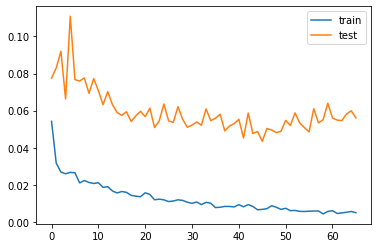

(35, 7)
(35, 7)
(35, 7)
score_train: [50.936] 43.8, 57.9, 61.9, 58.7, 48.4, 40.0, 41.1
(8, 1, 35)
score_test: [236.604] 207.6, 206.3, 287.3, 118.3, 305.2, 275.1, 202.2

RMSE test:  236.60443825085966 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0539 - val_loss: 0.0876
Epoch 2/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.0948
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0277 - val_loss: 0.1108
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.0811
Epoch 5/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0290 - val_loss: 0.1028
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0828
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0230 - val_loss: 0.0792
Epoch 8/1000
35/35 [=============================

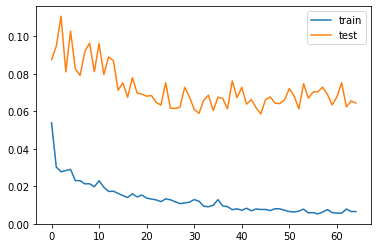

(35, 7)
(35, 7)
(35, 7)
score_train: [58.507] 52.6, 65.6, 62.3, 62.5, 59.9, 54.2, 50.8
(8, 1, 35)
score_test: [253.574] 283.6, 219.9, 351.8, 79.6, 347.1, 210.6, 162.3

RMSE test:  253.57431149491106 


Units CNN1:  127 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0849 - val_loss: 0.0918
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0352 - val_loss: 0.0710
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.0853
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.0695
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0275 - val_loss: 0.0867
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.0683
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0242 - val_loss: 0.0792
Epoch 8/1000
35/35 [==============================

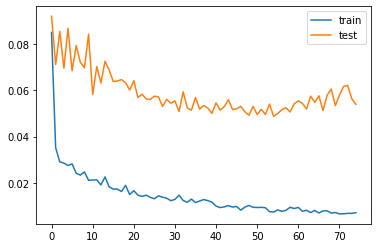

(35, 7)
(35, 7)
(35, 7)
score_train: [66.360] 63.6, 69.9, 79.1, 70.5, 58.2, 62.8, 57.8
(8, 1, 35)
score_test: [231.777] 174.3, 195.9, 312.3, 171.3, 284.9, 203.6, 240.3

RMSE test:  231.77685748445705 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0531 - val_loss: 0.0733
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0326 - val_loss: 0.1002
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.0985
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0263 - val_loss: 0.0834
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0252 - val_loss: 0.0730
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0231 - val_loss: 0.0603
Epoch 7/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0795
Epoch 8/1000
35/35 [=============================

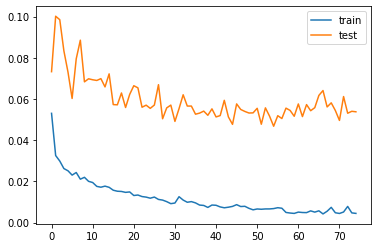

(35, 7)
(35, 7)
(35, 7)
score_train: [50.707] 41.9, 54.9, 55.2, 67.5, 48.1, 42.1, 39.2
(8, 1, 35)
score_test: [231.709] 264.1, 185.2, 254.5, 89.0, 344.7, 215.6, 183.8

RMSE test:  231.70915989878247 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0427 - val_loss: 0.0771
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.1561
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0311 - val_loss: 0.0782
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0259 - val_loss: 0.0848
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0257 - val_loss: 0.0963
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0664
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.0965
Epoch 8/1000
35/35 [==============================

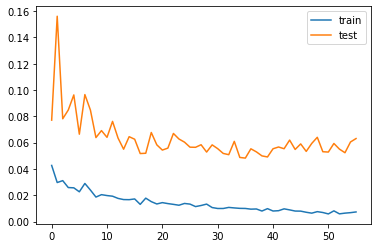

(35, 7)
(35, 7)
(35, 7)
score_train: [69.922] 73.0, 86.7, 79.9, 63.5, 56.0, 61.0, 64.1
(8, 1, 35)
score_test: [250.985] 173.4, 180.6, 342.8, 101.3, 354.4, 257.5, 242.1

RMSE test:  250.9848303811361 


Units CNN1:  239 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0500 - val_loss: 0.0774
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0346 - val_loss: 0.1039
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0322 - val_loss: 0.1206
Epoch 4/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0272 - val_loss: 0.0683
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0272 - val_loss: 0.0844
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0222 - val_loss: 0.0938
Epoch 7/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0817
Epoch 8/1000
35/35 [==============================

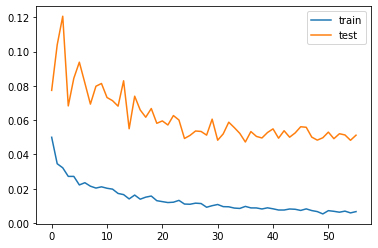

(35, 7)
(35, 7)
(35, 7)
score_train: [60.240] 60.0, 71.1, 63.8, 69.0, 55.0, 45.8, 52.8
(8, 1, 35)
score_test: [226.115] 263.5, 187.7, 237.1, 118.2, 311.9, 240.9, 166.5

RMSE test:  226.11455587885175 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 9ms/step - loss: 0.0482 - val_loss: 0.0805
Epoch 2/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.0968
Epoch 3/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.0761
Epoch 4/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0264 - val_loss: 0.0810
Epoch 5/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0889
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0268 - val_loss: 0.0840
Epoch 7/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0214 - val_loss: 0.0642
Epoch 8/1000
35/35 [=============================

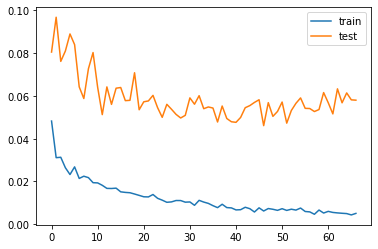

(35, 7)
(35, 7)
(35, 7)
score_train: [50.647] 44.6, 57.5, 56.0, 57.4, 50.0, 40.0, 46.2
(8, 1, 35)
score_test: [240.538] 199.2, 203.1, 305.8, 126.0, 311.6, 247.2, 237.7

RMSE test:  240.5379222919806 


Units CNN1:  124 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0598 - val_loss: 0.0730
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0347 - val_loss: 0.0827
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0275 - val_loss: 0.0709
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0269 - val_loss: 0.0781
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0275 - val_loss: 0.0755
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0238 - val_loss: 0.0735
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0222 - val_loss: 0.0683
Epoch 8/1000
35/35 [==============================

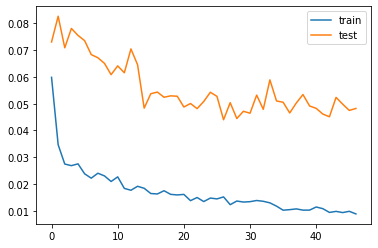

(35, 7)
(35, 7)
(35, 7)
score_train: [79.980] 73.8, 80.3, 95.2, 92.6, 77.4, 65.3, 70.7
(8, 1, 35)
score_test: [219.369] 291.5, 231.6, 165.7, 115.5, 315.3, 179.7, 160.4

RMSE test:  219.3689379351644 


Units CNN1:  191 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0469 - val_loss: 0.0785
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0342 - val_loss: 0.1097
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0704
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.0946
Epoch 5/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0272 - val_loss: 0.0926
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0259 - val_loss: 0.0923
Epoch 7/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0765
Epoch 8/1000
35/35 [==============================

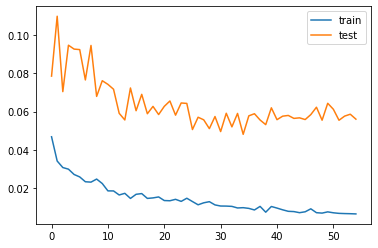

(35, 7)
(35, 7)
(35, 7)
score_train: [65.295] 58.8, 70.8, 77.3, 73.2, 66.5, 51.6, 54.4
(8, 1, 35)
score_test: [236.491] 285.2, 190.7, 289.2, 80.0, 297.9, 239.7, 193.7

RMSE test:  236.49101528059435 


Units CNN1:  251 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0504 - val_loss: 0.0787
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0344 - val_loss: 0.1011
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.0768
Epoch 4/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.0746
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0269 - val_loss: 0.0747
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0642
Epoch 7/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.0750
Epoch 8/1000
35/35 [==============================

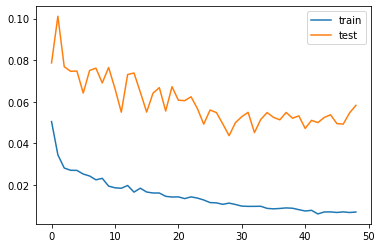

(35, 7)
(35, 7)
(35, 7)
score_train: [73.066] 63.6, 70.9, 82.0, 80.2, 73.2, 80.6, 57.4
(8, 1, 35)
score_test: [241.099] 295.1, 214.3, 248.7, 148.7, 375.4, 174.1, 136.5

RMSE test:  241.099361307858 

gen	nevals	avg    	std    	min    	max    
0  	10    	227.874	6.48298	219.369	236.604

Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0569 - val_loss: 0.0867
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0329 - val_loss: 0.1190
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.1014
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0255 - val_loss: 0.0880
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0256 - val_loss: 0.0741
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0235 - val_loss: 0.0718
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step

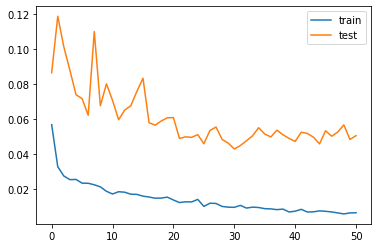

(35, 7)
(35, 7)
(35, 7)
score_train: [62.511] 61.7, 68.3, 73.5, 75.5, 54.3, 48.0, 50.1
(8, 1, 35)
score_test: [224.860] 225.1, 191.0, 261.6, 115.2, 300.7, 255.3, 171.6

RMSE test:  224.8601366637141 


Units CNN1:  246 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0466 - val_loss: 0.0842
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0309 - val_loss: 0.1189
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0337 - val_loss: 0.0807
Epoch 4/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0301 - val_loss: 0.0685
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.0741
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.0585
Epoch 7/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.1001
Epoch 8/1000
35/35 [==============================

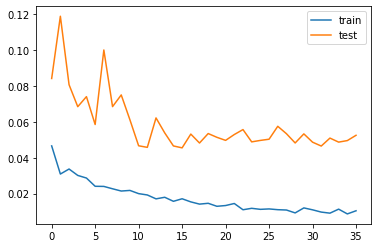

(35, 7)
(35, 7)
(35, 7)
score_train: [87.512] 76.7, 98.4, 99.2, 88.5, 80.8, 77.6, 88.3
(8, 1, 35)
score_test: [228.882] 224.4, 203.5, 264.1, 126.8, 222.9, 247.6, 279.5

RMSE test:  228.88159970686226 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0437 - val_loss: 0.0665
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.0892
Epoch 3/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0288 - val_loss: 0.0998
Epoch 4/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0261 - val_loss: 0.0658
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0236 - val_loss: 0.0831
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0243 - val_loss: 0.0691
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0231 - val_loss: 0.0654
Epoch 8/1000
35/35 [=============================

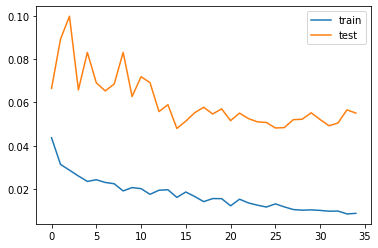

(35, 7)
(35, 7)
(35, 7)
score_train: [82.247] 77.3, 89.6, 87.7, 87.5, 85.0, 78.0, 68.5
(8, 1, 35)
score_test: [234.496] 271.1, 240.1, 279.4, 101.2, 228.4, 270.1, 200.9

RMSE test:  234.4962299133581 


Units CNN1:  254 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0391 - val_loss: 0.0818
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0329 - val_loss: 0.1099
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0324 - val_loss: 0.0926
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0266 - val_loss: 0.0705
Epoch 5/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0929
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0741
Epoch 7/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.0735
Epoch 8/1000
35/35 [==============================

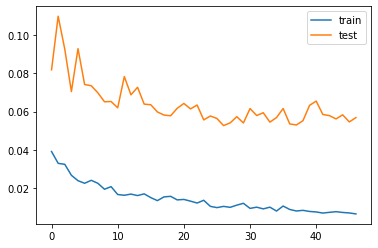

(35, 7)
(35, 7)
(35, 7)
score_train: [65.999] 59.5, 74.9, 80.6, 69.8, 58.1, 49.5, 64.4
(8, 1, 35)
score_test: [238.134] 246.0, 221.7, 291.8, 121.5, 279.1, 276.7, 181.4

RMSE test:  238.13383336060062 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0524 - val_loss: 0.0993
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0319 - val_loss: 0.0991
Epoch 3/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.0805
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0265 - val_loss: 0.0875
Epoch 5/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0254 - val_loss: 0.0686
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0254 - val_loss: 0.1013
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0246 - val_loss: 0.0756
Epoch 8/1000
35/35 [=============================

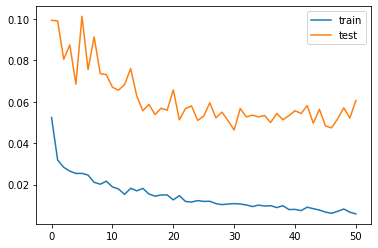

(35, 7)
(35, 7)
(35, 7)
score_train: [84.116] 104.6, 76.9, 75.8, 75.9, 82.5, 98.0, 68.8
(8, 1, 35)
score_test: [246.072] 328.8, 213.4, 264.9, 129.4, 359.8, 180.7, 145.7

RMSE test:  246.07244743388603 


Units CNN1:  254 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0549 - val_loss: 0.0935
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0384 - val_loss: 0.0937
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.0956
Epoch 4/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.1112
Epoch 5/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0680
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0241 - val_loss: 0.0906
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0209 - val_loss: 0.0640
Epoch 8/1000
35/35 [============================

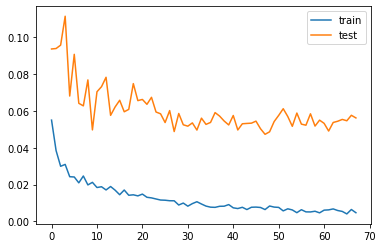

(35, 7)
(35, 7)
(35, 7)
score_train: [51.683] 51.9, 55.7, 59.4, 55.1, 51.6, 40.6, 45.0
(8, 1, 35)
score_test: [236.639] 241.5, 221.7, 248.4, 129.0, 344.8, 258.1, 143.9

RMSE test:  236.63869701222745 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0429 - val_loss: 0.1134
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0315 - val_loss: 0.0869
Epoch 3/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0886
Epoch 4/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.0645
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0263 - val_loss: 0.0867
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0226 - val_loss: 0.0804
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0242 - val_loss: 0.0737
Epoch 8/1000
35/35 [=============================

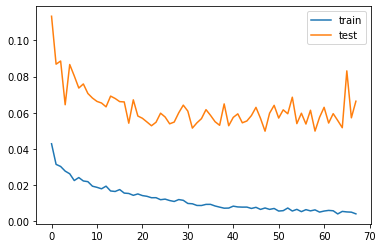

(35, 7)
(35, 7)
(35, 7)
score_train: [52.578] 38.6, 52.5, 80.3, 56.2, 42.5, 41.6, 44.2
(8, 1, 35)
score_test: [257.446] 223.0, 212.7, 410.8, 100.2, 279.9, 244.6, 228.1

RMSE test:  257.44642924060713 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0431 - val_loss: 0.0854
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0329 - val_loss: 0.0985
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0310 - val_loss: 0.0737
Epoch 4/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0919
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.0753
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0251 - val_loss: 0.0750
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0222 - val_loss: 0.0745
Epoch 8/1000
35/35 [=============================

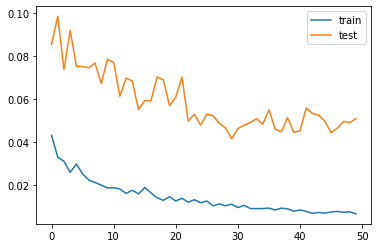

(35, 7)
(35, 7)
(35, 7)
score_train: [66.636] 61.8, 71.0, 81.1, 76.8, 63.3, 53.4, 54.0
(8, 1, 35)
score_test: [225.236] 239.9, 254.5, 207.9, 117.9, 330.0, 220.9, 134.3

RMSE test:  225.23555634640653 

1  	8     	220.043	2.02369	219.369	226.115

Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0542 - val_loss: 0.0678
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0309 - val_loss: 0.0737
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.0874
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.0849
Epoch 5/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.0820
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0223 - val_loss: 0.0660
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0258 - val_loss: 0.0722
Epoch 

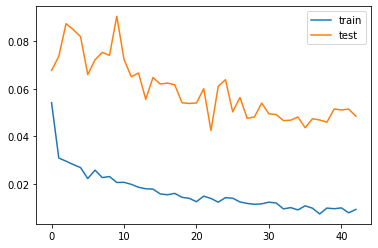

(35, 7)
(35, 7)
(35, 7)
score_train: [72.920] 76.8, 75.0, 78.5, 88.8, 65.3, 60.1, 61.4
(8, 1, 35)
score_test: [219.976] 242.0, 225.7, 277.7, 97.1, 278.0, 200.5, 158.6

RMSE test:  219.97630091471973 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0581 - val_loss: 0.0884
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.0972
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.1013
Epoch 4/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0272 - val_loss: 0.0773
Epoch 5/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0264 - val_loss: 0.0753
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0951
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0262 - val_loss: 0.0733
Epoch 8/1000
35/35 [==============================

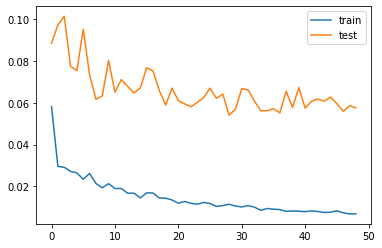

(35, 7)
(35, 7)
(35, 7)
score_train: [68.014] 62.0, 81.9, 75.8, 76.0, 57.3, 56.0, 62.3
(8, 1, 35)
score_test: [239.594] 264.3, 232.2, 246.4, 139.2, 310.6, 263.1, 179.8

RMSE test:  239.5937019733014 


Units CNN1:  239 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0531 - val_loss: 0.0843
Epoch 2/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0320 - val_loss: 0.1247
Epoch 3/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0333 - val_loss: 0.1063
Epoch 4/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.1116
Epoch 5/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0935
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0234 - val_loss: 0.0893
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0247 - val_loss: 0.0765
Epoch 8/1000
35/35 [==============================

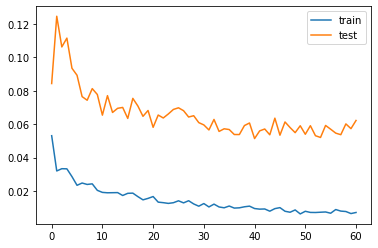

(35, 7)
(35, 7)
(35, 7)
score_train: [73.455] 57.3, 65.9, 76.2, 78.2, 84.8, 81.0, 66.9
(8, 1, 35)
score_test: [249.182] 197.4, 238.3, 346.5, 98.7, 362.9, 238.0, 143.9

RMSE test:  249.18237530915263 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 11ms/step - loss: 0.0411 - val_loss: 0.0769
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0315 - val_loss: 0.0770
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0265 - val_loss: 0.0982
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.0811
Epoch 5/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0868
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0224 - val_loss: 0.0826
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0216 - val_loss: 0.0983
Epoch 8/1000
35/35 [=============================

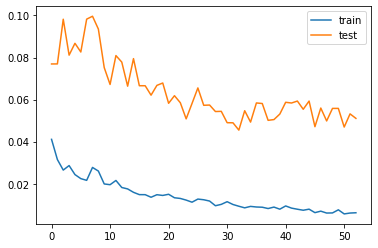

(35, 7)
(35, 7)
(35, 7)
score_train: [64.539] 52.7, 68.8, 67.1, 74.8, 53.5, 65.7, 66.2
(8, 1, 35)
score_test: [225.756] 240.5, 199.5, 244.7, 144.0, 349.0, 214.4, 103.5

RMSE test:  225.75587018373005 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0424 - val_loss: 0.0819
Epoch 2/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.0777
Epoch 3/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0250 - val_loss: 0.0926
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0270 - val_loss: 0.0693
Epoch 5/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0622
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0674
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0260 - val_loss: 0.1007
Epoch 8/1000
35/35 [=============================

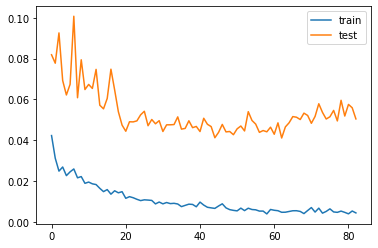

(35, 7)
(35, 7)
(35, 7)
score_train: [48.424] 49.6, 55.2, 54.3, 50.0, 35.8, 42.0, 49.2
(8, 1, 35)
score_test: [224.477] 161.1, 192.0, 289.4, 58.0, 278.9, 277.2, 219.5

RMSE test:  224.47748027481472 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0362 - val_loss: 0.0746
Epoch 2/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0928
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0277 - val_loss: 0.0658
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0269 - val_loss: 0.0766
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0234 - val_loss: 0.0638
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0669
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0243 - val_loss: 0.0609
Epoch 8/1000
35/35 [==============================

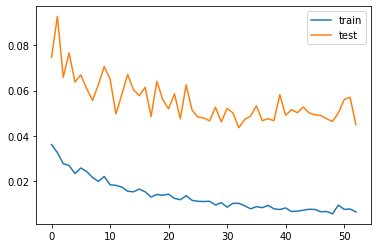

(35, 7)
(35, 7)
(35, 7)
score_train: [65.681] 56.5, 65.7, 89.9, 68.4, 67.6, 54.6, 48.8
(8, 1, 35)
score_test: [211.939] 237.0, 179.3, 250.5, 105.2, 267.7, 228.8, 168.2

RMSE test:  211.93887760697237 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0344 - val_loss: 0.0636
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.0752
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0266 - val_loss: 0.0732
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0246 - val_loss: 0.0577
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0257 - val_loss: 0.0783
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0677
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0216 - val_loss: 0.0517
Epoch 8/1000
35/35 [=============================

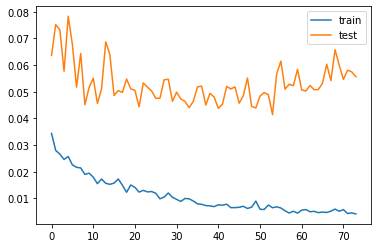

(35, 7)
(35, 7)
(35, 7)
score_train: [45.914] 46.8, 49.3, 54.3, 53.0, 38.4, 39.2, 37.0
(8, 1, 35)
score_test: [235.543] 177.1, 200.8, 306.5, 136.1, 315.0, 248.5, 208.0

RMSE test:  235.54293424655776 

2  	7     	217.883	2.97202	211.939	219.369

Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0417 - val_loss: 0.0938
Epoch 2/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0966
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.0817
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.0733
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0264 - val_loss: 0.0858
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0240 - val_loss: 0.0648
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0228 - val_loss: 0.0723
Epoch 

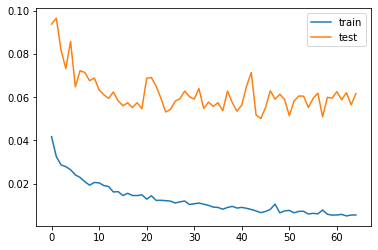

(35, 7)
(35, 7)
(35, 7)
score_train: [59.088] 52.4, 63.7, 58.7, 60.7, 66.0, 58.0, 52.7
(8, 1, 35)
score_test: [248.077] 201.4, 248.6, 323.0, 163.1, 352.8, 207.3, 173.5

RMSE test:  248.07727906150922 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0469 - val_loss: 0.0651
Epoch 2/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0318 - val_loss: 0.0690
Epoch 3/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.0734
Epoch 4/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0747
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0267 - val_loss: 0.0701
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0212 - val_loss: 0.0564
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0230 - val_loss: 0.0514
Epoch 8/1000
35/35 [=============================

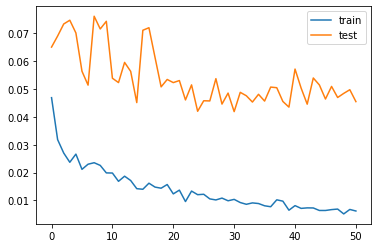

(35, 7)
(35, 7)
(35, 7)
score_train: [65.888] 60.1, 78.4, 82.7, 67.5, 55.6, 51.5, 59.2
(8, 1, 35)
score_test: [213.064] 257.8, 183.5, 180.9, 112.7, 324.4, 192.2, 173.2

RMSE test:  213.06404999626062 


Units CNN1:  251 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0513 - val_loss: 0.0942
Epoch 2/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.1027
Epoch 3/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0287 - val_loss: 0.0922
Epoch 4/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0777
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0229 - val_loss: 0.0904
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0250 - val_loss: 0.0836
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0206 - val_loss: 0.0738
Epoch 8/1000
35/35 [=============================

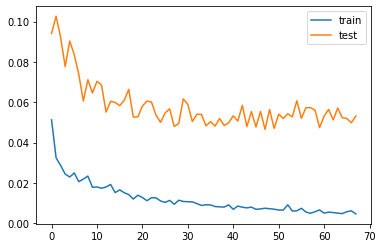

(35, 7)
(35, 7)
(35, 7)
score_train: [58.570] 47.7, 84.0, 64.9, 58.0, 46.7, 43.8, 55.0
(8, 1, 35)
score_test: [230.449] 251.5, 215.6, 305.3, 122.0, 296.4, 190.8, 172.1

RMSE test:  230.4494564709965 


Units CNN1:  190 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0594 - val_loss: 0.0811
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0966
Epoch 3/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.0917
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.0920
Epoch 5/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0689
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0812
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0230 - val_loss: 0.0772
Epoch 8/1000
35/35 [==============================

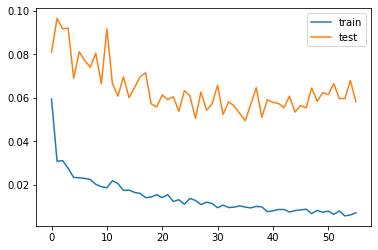

(35, 7)
(35, 7)
(35, 7)
score_train: [66.727] 63.1, 64.9, 78.0, 71.5, 64.8, 64.2, 58.9
(8, 1, 35)
score_test: [241.044] 392.2, 222.9, 182.5, 101.8, 315.6, 218.4, 110.6

RMSE test:  241.0436088885901 


Units CNN1:  254 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0450 - val_loss: 0.0859
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0342 - val_loss: 0.0886
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.0938
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.0775
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0248 - val_loss: 0.0874
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.0654
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0226 - val_loss: 0.0746
Epoch 8/1000
35/35 [==============================

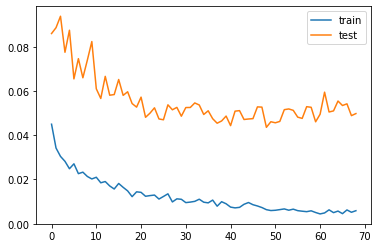

(35, 7)
(35, 7)
(35, 7)
score_train: [69.434] 49.5, 59.3, 71.2, 59.9, 90.8, 83.0, 63.3
(8, 1, 35)
score_test: [222.844] 278.5, 222.2, 186.6, 51.4, 343.2, 188.2, 173.1

RMSE test:  222.84386401115432 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0610 - val_loss: 0.0788
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0336 - val_loss: 0.0974
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.0851
Epoch 4/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0264 - val_loss: 0.0833
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0252 - val_loss: 0.0762
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.0675
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0228 - val_loss: 0.0788
Epoch 8/1000
35/35 [==============================

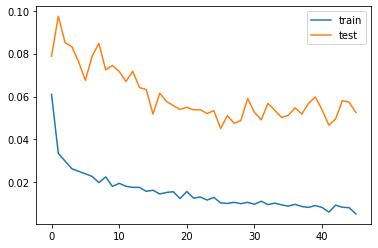

(35, 7)
(35, 7)
(35, 7)
score_train: [65.115] 64.1, 71.7, 76.1, 72.1, 63.1, 52.2, 52.4
(8, 1, 35)
score_test: [229.030] 284.8, 247.7, 276.8, 89.7, 259.4, 214.4, 163.8

RMSE test:  229.03027072900147 


Units CNN1:  191 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0621 - val_loss: 0.0827
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0270 - val_loss: 0.0693
Epoch 3/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0659
Epoch 4/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.0728
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0239 - val_loss: 0.0762
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0245 - val_loss: 0.0675
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0222 - val_loss: 0.0705
Epoch 8/1000
35/35 [==============================

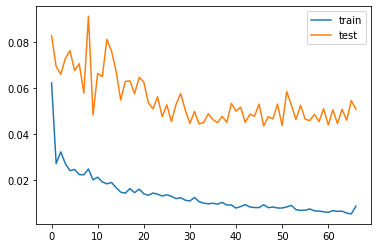

(35, 7)
(35, 7)
(35, 7)
score_train: [62.421] 48.8, 67.5, 66.4, 66.2, 63.6, 70.1, 50.9
(8, 1, 35)
score_test: [224.931] 229.8, 226.0, 268.0, 89.5, 269.8, 248.9, 188.8

RMSE test:  224.9305828801576 


Units CNN1:  246 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0498 - val_loss: 0.0909
Epoch 2/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.1132
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.1051
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0283 - val_loss: 0.0953
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0266 - val_loss: 0.0793
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.1045
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0243 - val_loss: 0.0795
Epoch 8/1000
35/35 [==============================]

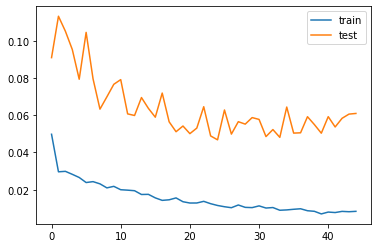

(35, 7)
(35, 7)
(35, 7)
score_train: [70.754] 63.0, 77.9, 82.3, 85.7, 65.1, 58.5, 56.9
(8, 1, 35)
score_test: [246.657] 252.0, 246.5, 250.8, 143.0, 353.9, 230.1, 200.1

RMSE test:  246.65730434157328 

3  	8     	212.682	2.22902	211.939	219.369

Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0405 - val_loss: 0.0529
Epoch 2/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0657
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.0881
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.0756
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0248 - val_loss: 0.0660
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0240 - val_loss: 0.0636
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0204 - val_loss: 0.0593
Epoch 

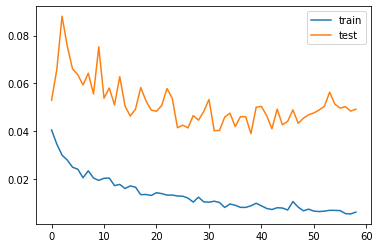

(35, 7)
(35, 7)
(35, 7)
score_train: [57.887] 55.6, 60.2, 64.8, 62.4, 56.9, 55.9, 47.8
(8, 1, 35)
score_test: [221.486] 248.6, 216.1, 297.8, 109.5, 244.9, 196.3, 189.0

RMSE test:  221.48590027824815 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0627 - val_loss: 0.0828
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.1047
Epoch 3/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.0858
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.0713
Epoch 5/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0276 - val_loss: 0.0573
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0936
Epoch 7/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0245 - val_loss: 0.0772
Epoch 8/1000
35/35 [=============================

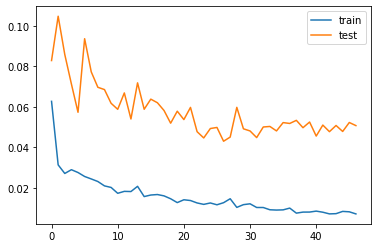

(35, 7)
(35, 7)
(35, 7)
score_train: [69.360] 61.5, 81.9, 83.0, 74.5, 62.4, 52.5, 64.1
(8, 1, 35)
score_test: [225.035] 289.5, 189.4, 258.9, 143.4, 290.4, 219.1, 121.6

RMSE test:  225.03542513457313 


Units CNN1:  239 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0512 - val_loss: 0.0920
Epoch 2/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0318 - val_loss: 0.0765
Epoch 3/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.1050
Epoch 4/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0276 - val_loss: 0.0892
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0275 - val_loss: 0.0675
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0259 - val_loss: 0.0972
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0258 - val_loss: 0.0722
Epoch 8/1000
35/35 [=============================

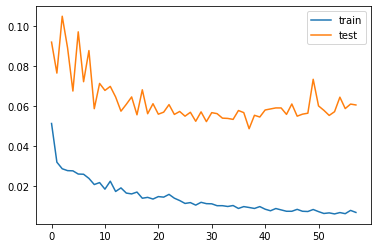

(35, 7)
(35, 7)
(35, 7)
score_train: [69.023] 58.5, 63.4, 80.8, 70.2, 69.3, 68.4, 70.5
(8, 1, 35)
score_test: [245.735] 336.7, 233.2, 234.3, 107.9, 348.9, 218.7, 137.3

RMSE test:  245.73499477714918 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0504 - val_loss: 0.0797
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0333 - val_loss: 0.0891
Epoch 3/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.0825
Epoch 4/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0262 - val_loss: 0.0757
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0253 - val_loss: 0.0781
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0252 - val_loss: 0.0787
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0223 - val_loss: 0.0821
Epoch 8/1000
35/35 [=============================

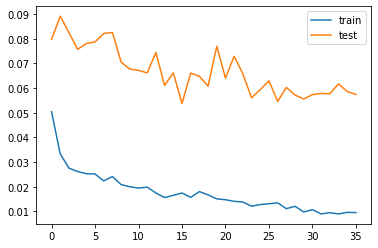

(35, 7)
(35, 7)
(35, 7)
score_train: [82.389] 82.2, 87.5, 99.8, 90.7, 72.5, 66.8, 72.3
(8, 1, 35)
score_test: [239.360] 337.8, 227.5, 268.0, 132.1, 303.5, 196.8, 122.8

RMSE test:  239.35971081679207 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0467 - val_loss: 0.0781
Epoch 2/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0907
Epoch 3/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0288 - val_loss: 0.0681
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.0760
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.1022
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0763
Epoch 7/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0695
Epoch 8/1000
35/35 [=============================

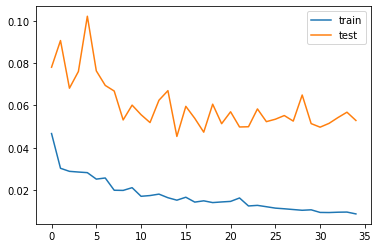

(35, 7)
(35, 7)
(35, 7)
score_train: [78.116] 76.0, 87.4, 88.6, 89.1, 73.7, 60.3, 66.7
(8, 1, 35)
score_test: [229.739] 251.7, 212.8, 225.0, 93.2, 371.6, 218.2, 125.5

RMSE test:  229.73869046334534 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0514 - val_loss: 0.0717
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0311 - val_loss: 0.0853
Epoch 3/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0291 - val_loss: 0.1060
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0275 - val_loss: 0.0992
Epoch 5/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0261 - val_loss: 0.0697
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0806
Epoch 7/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0794
Epoch 8/1000
35/35 [==============================

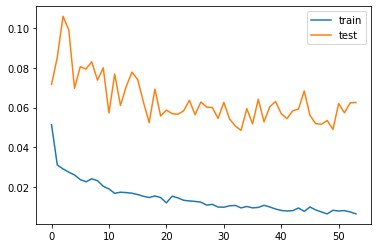

(35, 7)
(35, 7)
(35, 7)
score_train: [65.196] 57.8, 71.0, 75.4, 74.5, 63.2, 52.3, 58.4
(8, 1, 35)
score_test: [249.929] 259.2, 220.9, 330.5, 128.3, 348.3, 241.6, 126.1

RMSE test:  249.92945697512263 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0591 - val_loss: 0.0706
Epoch 2/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0292 - val_loss: 0.1228
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0327 - val_loss: 0.0593
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0325 - val_loss: 0.0733
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0257 - val_loss: 0.0714
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0239 - val_loss: 0.0898
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0250 - val_loss: 0.0795
Epoch 8/1000
35/35 [=============================

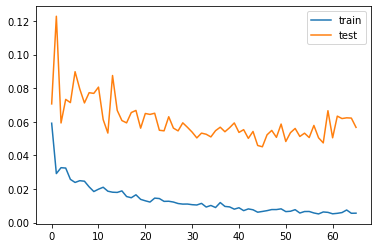

(35, 7)
(35, 7)
(35, 7)
score_train: [54.248] 55.3, 61.0, 54.3, 60.9, 47.2, 42.4, 56.1
(8, 1, 35)
score_test: [237.812] 243.7, 189.9, 342.1, 105.5, 272.8, 248.1, 190.4

RMSE test:  237.81151259909748 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0471 - val_loss: 0.0799
Epoch 2/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.1016
Epoch 3/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0885
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0256 - val_loss: 0.0790
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0250 - val_loss: 0.0667
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0720
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0224 - val_loss: 0.0813
Epoch 8/1000
35/35 [=============================

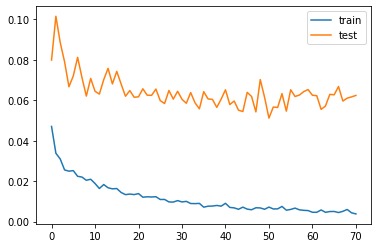

(35, 7)
(35, 7)
(35, 7)
score_train: [47.905] 42.4, 49.4, 63.2, 46.7, 41.7, 49.6, 38.1
(8, 1, 35)
score_test: [249.596] 288.4, 185.3, 313.2, 163.0, 314.2, 269.7, 149.8

RMSE test:  249.59643761305526 


Units CNN1:  253 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0570 - val_loss: 0.1034
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0310 - val_loss: 0.0997
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0277 - val_loss: 0.1010
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.1090
Epoch 5/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.1041
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.0943
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0234 - val_loss: 0.0845
Epoch 8/1000
35/35 [=============================

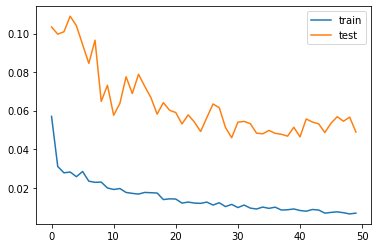

(35, 7)
(35, 7)
(35, 7)
score_train: [61.094] 56.2, 69.5, 74.4, 67.4, 53.5, 54.6, 47.2
(8, 1, 35)
score_test: [220.873] 269.5, 206.2, 247.9, 74.8, 286.0, 241.4, 138.6

RMSE test:  220.87314445942408 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0564 - val_loss: 0.0774
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0307 - val_loss: 0.0868
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0258 - val_loss: 0.0777
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.0625
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0256 - val_loss: 0.1111
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0253 - val_loss: 0.0705
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0227 - val_loss: 0.0792
Epoch 8/1000
35/35 [==============================

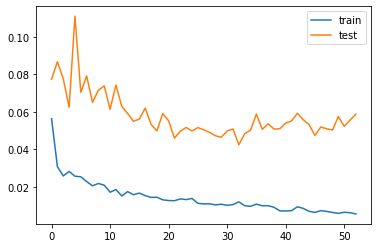

(35, 7)
(35, 7)
(35, 7)
score_train: [62.629] 50.1, 73.1, 75.0, 63.6, 64.3, 56.1, 51.5
(8, 1, 35)
score_test: [242.232] 228.3, 209.0, 342.3, 112.3, 266.9, 286.0, 179.2

RMSE test:  242.23202455476383 

4  	10    	211.939	2.84217e-14	211.939	211.939

Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0371 - val_loss: 0.0849
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0332 - val_loss: 0.0877
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.0802
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0283 - val_loss: 0.0842
Epoch 5/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0245 - val_loss: 0.0723
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0260 - val_loss: 0.0710
Epoch 7/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0204 - val_loss: 0.0708
Ep

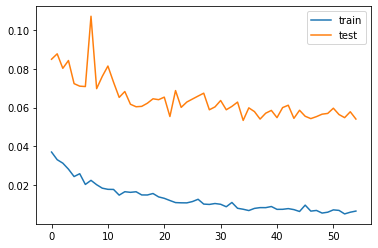

(35, 7)
(35, 7)
(35, 7)
score_train: [63.672] 70.1, 78.6, 78.4, 68.6, 48.8, 47.0, 42.8
(8, 1, 35)
score_test: [232.344] 243.6, 225.4, 275.8, 116.8, 298.0, 229.4, 191.4

RMSE test:  232.34355433761297 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0510 - val_loss: 0.0743
Epoch 2/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0999
Epoch 3/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0293 - val_loss: 0.0905
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0269 - val_loss: 0.0963
Epoch 5/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0865
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.0797
Epoch 7/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0711
Epoch 8/1000
35/35 [=============================

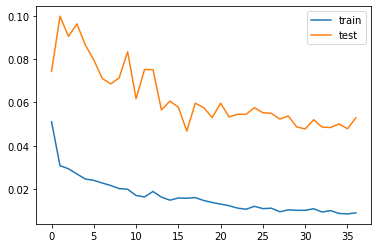

(35, 7)
(35, 7)
(35, 7)
score_train: [73.195] 76.7, 78.1, 86.5, 86.1, 64.4, 56.9, 56.9
(8, 1, 35)
score_test: [229.808] 275.9, 244.3, 284.6, 97.8, 259.8, 235.4, 143.0

RMSE test:  229.80842974585948 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0445 - val_loss: 0.0598
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0311 - val_loss: 0.0863
Epoch 3/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0324 - val_loss: 0.0784
Epoch 4/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.0742
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0233 - val_loss: 0.0869
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0240 - val_loss: 0.0542
Epoch 7/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0636
Epoch 8/1000
35/35 [==============================

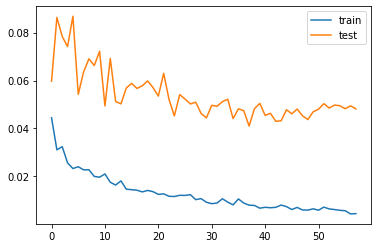

(35, 7)
(35, 7)
(35, 7)
score_train: [51.680] 52.0, 56.0, 54.0, 61.2, 43.7, 46.6, 45.8
(8, 1, 35)
score_test: [219.287] 218.5, 188.0, 341.0, 90.4, 275.6, 174.8, 150.2

RMSE test:  219.28733159855253 


Units CNN1:  191 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0555 - val_loss: 0.0594
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.1006
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.0787
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0267 - val_loss: 0.0929
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0249 - val_loss: 0.0702
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0266 - val_loss: 0.0805
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0211 - val_loss: 0.0667
Epoch 8/1000
35/35 [==============================

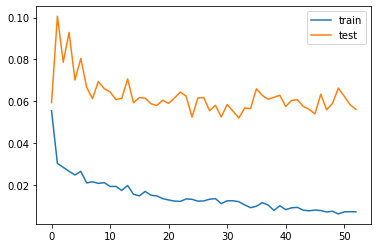

(35, 7)
(35, 7)
(35, 7)
score_train: [64.364] 63.8, 79.2, 72.5, 66.8, 51.4, 52.8, 59.1
(8, 1, 35)
score_test: [236.780] 320.8, 267.9, 282.0, 115.6, 279.3, 171.0, 132.7

RMSE test:  236.7803634362006 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0452 - val_loss: 0.0434
Epoch 2/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0333 - val_loss: 0.0875
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0329 - val_loss: 0.0819
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0270 - val_loss: 0.0871
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0258 - val_loss: 0.0669
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0275 - val_loss: 0.0602
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0240 - val_loss: 0.0550
Epoch 8/1000
35/35 [==============================

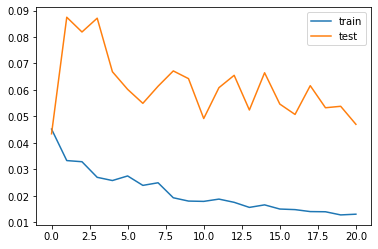

(35, 7)
(35, 7)
(35, 7)
score_train: [98.449] 100.6, 97.7, 118.4, 109.5, 87.5, 84.1, 86.2
(8, 1, 35)
score_test: [216.648] 304.6, 232.8, 126.5, 142.0, 322.5, 172.7, 107.6

RMSE test:  216.6475195418578 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0513 - val_loss: 0.0920
Epoch 2/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.0898
Epoch 3/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0315 - val_loss: 0.0988
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0302 - val_loss: 0.0855
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0219 - val_loss: 0.0779
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0234 - val_loss: 0.0813
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0256 - val_loss: 0.0675
Epoch 8/1000
35/35 [===========================

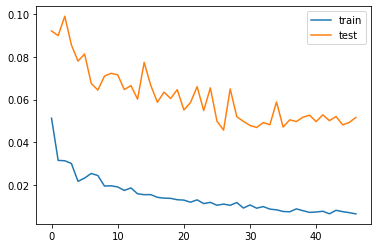

(35, 7)
(35, 7)
(35, 7)
score_train: [68.875] 60.4, 87.4, 78.7, 77.9, 59.0, 53.4, 57.6
(8, 1, 35)
score_test: [227.085] 255.5, 254.3, 229.2, 128.8, 304.6, 201.5, 168.8

RMSE test:  227.08525422204576 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0444 - val_loss: 0.0708
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0345 - val_loss: 0.1010
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0316 - val_loss: 0.0706
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0257 - val_loss: 0.0835
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0258 - val_loss: 0.0680
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0256 - val_loss: 0.0613
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0257 - val_loss: 0.0624
Epoch 8/1000
35/35 [=============================

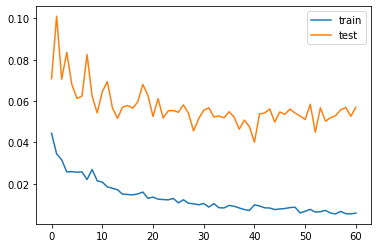

(35, 7)
(35, 7)
(35, 7)
score_train: [57.974] 57.9, 60.9, 65.4, 70.0, 52.9, 47.8, 47.0
(8, 1, 35)
score_test: [238.519] 280.4, 185.8, 329.4, 134.1, 279.5, 215.2, 185.0

RMSE test:  238.51949959372948 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0495 - val_loss: 0.0879
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.1102
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.0788
Epoch 4/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0261 - val_loss: 0.0947
Epoch 5/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0248 - val_loss: 0.0963
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0794
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0239 - val_loss: 0.0778
Epoch 8/1000
35/35 [=============================

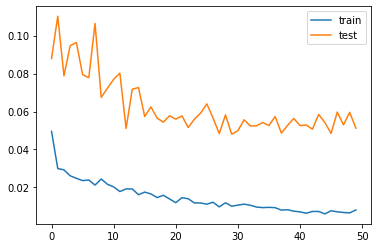

(35, 7)
(35, 7)
(35, 7)
score_train: [77.434] 64.4, 72.4, 79.6, 80.9, 77.9, 74.2, 90.3
(8, 1, 35)
score_test: [226.114] 230.6, 200.0, 301.5, 120.9, 321.8, 182.6, 149.3

RMSE test:  226.1135296950808 

5  	8     	211.939	2.84217e-14	211.939	211.939

Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0498 - val_loss: 0.1058
Epoch 2/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0300 - val_loss: 0.0909
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.0907
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0235 - val_loss: 0.0879
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0244 - val_loss: 0.0811
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0807
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0236 - val_loss: 0.0647
Epo

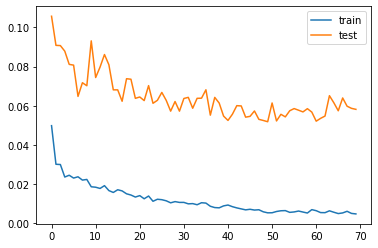

(35, 7)
(35, 7)
(35, 7)
score_train: [47.630] 37.1, 53.8, 53.2, 53.4, 51.3, 37.5, 43.6
(8, 1, 35)
score_test: [240.826] 244.1, 227.2, 320.0, 106.8, 354.0, 180.5, 151.8

RMSE test:  240.82637709035092 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0491 - val_loss: 0.1054
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.1042
Epoch 3/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.0918
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0255 - val_loss: 0.1000
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0256 - val_loss: 0.0874
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0239 - val_loss: 0.0820
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0244 - val_loss: 0.0902
Epoch 8/1000
35/35 [=============================

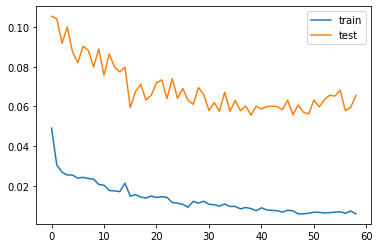

(35, 7)
(35, 7)
(35, 7)
score_train: [60.818] 58.3, 76.7, 73.8, 68.5, 52.1, 42.0, 44.9
(8, 1, 35)
score_test: [255.703] 232.0, 215.0, 340.7, 82.0, 330.6, 287.9, 206.5

RMSE test:  255.70276962597228 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0463 - val_loss: 0.0913
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.1186
Epoch 3/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0292 - val_loss: 0.0868
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.0790
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0243 - val_loss: 0.1051
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.0735
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0221 - val_loss: 0.0795
Epoch 8/1000
35/35 [==============================

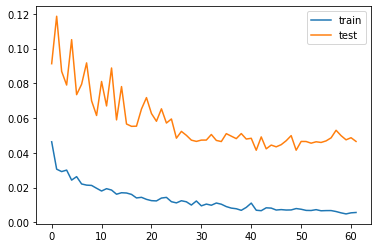

(35, 7)
(35, 7)
(35, 7)
score_train: [61.433] 53.6, 75.7, 62.8, 61.2, 47.2, 47.4, 75.1
(8, 1, 35)
score_test: [215.531] 234.2, 194.3, 290.4, 119.8, 225.9, 237.1, 163.1

RMSE test:  215.53084818702092 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0542 - val_loss: 0.0999
Epoch 2/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0860
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.0917
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0265 - val_loss: 0.0945
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0244 - val_loss: 0.0746
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0228 - val_loss: 0.0671
Epoch 7/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0678
Epoch 8/1000
35/35 [=============================

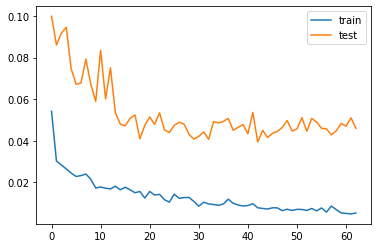

(35, 7)
(35, 7)
(35, 7)
score_train: [57.090] 51.3, 53.4, 68.1, 73.3, 54.1, 47.9, 45.8
(8, 1, 35)
score_test: [214.305] 218.9, 184.7, 322.6, 84.9, 219.1, 209.5, 190.5

RMSE test:  214.30498706568142 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0476 - val_loss: 0.0607
Epoch 2/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0846
Epoch 3/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.0845
Epoch 4/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0273 - val_loss: 0.0796
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0246 - val_loss: 0.0685
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0253 - val_loss: 0.0771
Epoch 7/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0813
Epoch 8/1000
35/35 [==============================

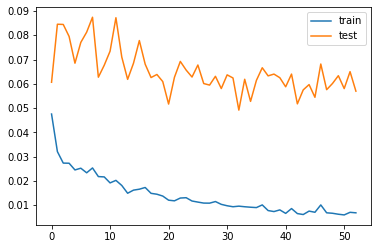

(35, 7)
(35, 7)
(35, 7)
score_train: [61.630] 62.5, 69.1, 70.6, 63.4, 57.8, 52.4, 53.0
(8, 1, 35)
score_test: [238.523] 247.7, 205.6, 249.4, 140.0, 355.1, 259.4, 139.5

RMSE test:  238.52275371302173 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0633 - val_loss: 0.0830
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0302 - val_loss: 0.1064
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0317 - val_loss: 0.1032
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0256 - val_loss: 0.0983
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0262 - val_loss: 0.0801
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0244 - val_loss: 0.0756
Epoch 7/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.0836
Epoch 8/1000
35/35 [=============================

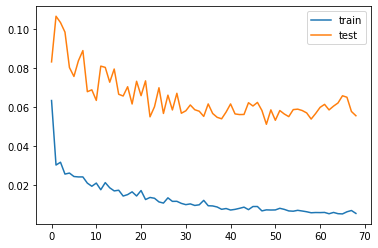

(35, 7)
(35, 7)
(35, 7)
score_train: [53.710] 50.3, 62.1, 60.8, 61.7, 45.2, 45.9, 46.3
(8, 1, 35)
score_test: [235.328] 242.8, 178.2, 251.2, 114.5, 364.0, 243.2, 170.4

RMSE test:  235.32831859834678 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0492 - val_loss: 0.0806
Epoch 2/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.0926
Epoch 3/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.0886
Epoch 4/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0279 - val_loss: 0.0913
Epoch 5/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0908
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0913
Epoch 7/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0865
Epoch 8/1000
35/35 [=============================

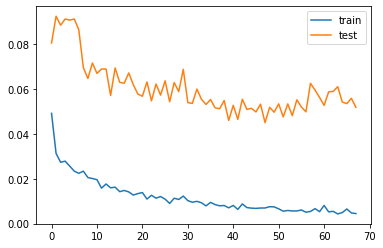

(35, 7)
(35, 7)
(35, 7)
score_train: [55.474] 47.2, 68.3, 73.0, 56.6, 49.6, 39.2, 45.9
(8, 1, 35)
score_test: [227.623] 250.1, 251.4, 287.3, 110.4, 262.8, 235.4, 133.1

RMSE test:  227.6233036723898 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0471 - val_loss: 0.0711
Epoch 2/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0304 - val_loss: 0.1086
Epoch 3/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0909
Epoch 4/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0289 - val_loss: 0.0736
Epoch 5/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0272 - val_loss: 0.0755
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.0788
Epoch 7/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0716
Epoch 8/1000
35/35 [==============================

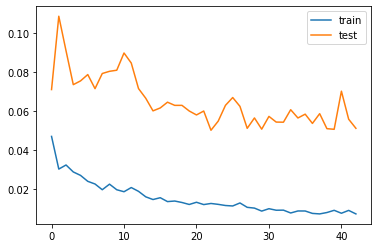

(35, 7)
(35, 7)
(35, 7)
score_train: [71.848] 67.2, 86.2, 82.2, 73.0, 72.4, 60.3, 56.6
(8, 1, 35)
score_test: [226.168] 273.2, 253.6, 267.9, 74.7, 276.4, 219.4, 131.3

RMSE test:  226.16750920112588 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0516 - val_loss: 0.0830
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.0971
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.1157
Epoch 4/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0262 - val_loss: 0.1131
Epoch 5/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0248 - val_loss: 0.0765
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0229 - val_loss: 0.0989
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0242 - val_loss: 0.0931
Epoch 8/1000
35/35 [==============================

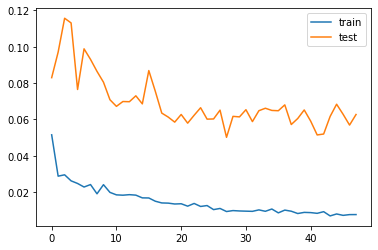

(35, 7)
(35, 7)
(35, 7)
score_train: [77.885] 69.4, 82.8, 96.2, 77.6, 62.2, 64.5, 86.6
(8, 1, 35)
score_test: [250.230] 224.2, 190.8, 354.1, 84.4, 356.5, 231.2, 196.4

RMSE test:  250.2303594690257 

6  	9     	211.939	2.84217e-14	211.939	211.939

Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0750 - val_loss: 0.0984
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0323 - val_loss: 0.0806
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.0760
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0283 - val_loss: 0.0852
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0246 - val_loss: 0.0699
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0229 - val_loss: 0.0921
Epoch 7/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0255 - val_loss: 0.0628
Epoc

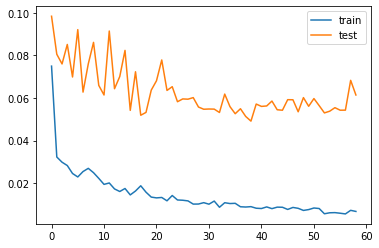

(35, 7)
(35, 7)
(35, 7)
score_train: [63.884] 55.4, 72.7, 72.7, 68.5, 60.1, 60.8, 54.1
(8, 1, 35)
score_test: [247.587] 285.9, 184.4, 351.7, 101.1, 328.9, 224.3, 145.0

RMSE test:  247.58697729106262 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0545 - val_loss: 0.0948
Epoch 2/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0389 - val_loss: 0.1073
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0986
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.0671
Epoch 5/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0279 - val_loss: 0.1014
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0743
Epoch 7/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0213 - val_loss: 0.0726
Epoch 8/1000
35/35 [=============================

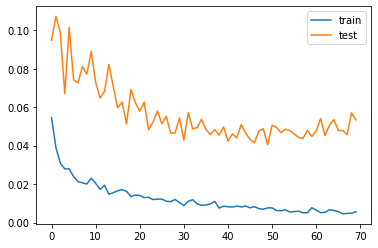

(35, 7)
(35, 7)
(35, 7)
score_train: [55.692] 47.6, 64.4, 60.6, 62.9, 58.0, 41.5, 50.7
(8, 1, 35)
score_test: [230.771] 252.1, 191.4, 346.2, 169.4, 217.2, 223.9, 163.5

RMSE test:  230.77105209304597 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0768 - val_loss: 0.1132
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.1033
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.1094
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0335 - val_loss: 0.0817
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0260 - val_loss: 0.0914
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0265 - val_loss: 0.0955
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0243 - val_loss: 0.0830
Epoch 8/1000
35/35 [=============================

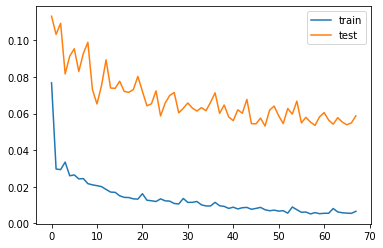

(35, 7)
(35, 7)
(35, 7)
score_train: [62.687] 69.0, 81.9, 61.0, 66.3, 52.9, 46.2, 54.8
(8, 1, 35)
score_test: [242.225] 246.5, 230.3, 220.5, 109.9, 424.7, 198.2, 128.7

RMSE test:  242.2253547860087 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0600 - val_loss: 0.0612
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.1005
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.0943
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.0787
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0269 - val_loss: 0.0779
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0228 - val_loss: 0.0573
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0224 - val_loss: 0.0849
Epoch 8/1000
35/35 [==============================

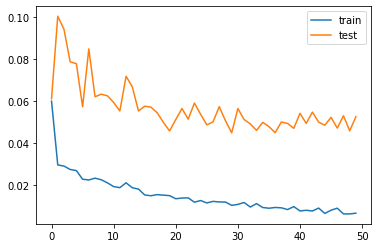

(35, 7)
(35, 7)
(35, 7)
score_train: [70.697] 63.8, 72.2, 75.9, 78.2, 69.4, 80.9, 49.7
(8, 1, 35)
score_test: [228.997] 230.2, 199.8, 308.5, 100.0, 294.8, 225.9, 176.1

RMSE test:  228.99681231657323 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0511 - val_loss: 0.0776
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0316 - val_loss: 0.0832
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.1015
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0812
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0248 - val_loss: 0.0810
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.0806
Epoch 7/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0863
Epoch 8/1000
35/35 [=============================

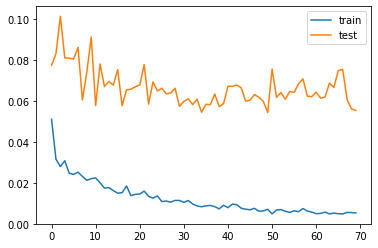

(35, 7)
(35, 7)
(35, 7)
score_train: [60.971] 49.5, 67.0, 75.7, 65.2, 42.6, 52.2, 67.5
(8, 1, 35)
score_test: [235.165] 213.8, 177.5, 290.9, 120.2, 315.6, 249.5, 221.4

RMSE test:  235.16520794261703 

7  	5     	211.939	2.84217e-14	211.939	211.939

Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0509 - val_loss: 0.0646
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0327 - val_loss: 0.0858
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0262 - val_loss: 0.0723
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.0835
Epoch 5/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.0746
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0208 - val_loss: 0.0679
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0252 - val_loss: 0.0610
Ep

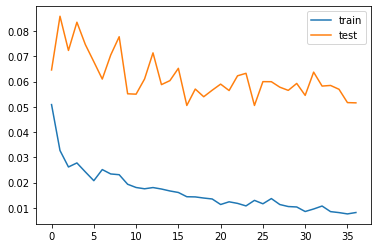

(35, 7)
(35, 7)
(35, 7)
score_train: [76.116] 73.6, 84.0, 88.8, 81.7, 71.7, 69.4, 59.7
(8, 1, 35)
score_test: [226.866] 251.5, 221.3, 257.0, 80.2, 329.3, 199.3, 165.4

RMSE test:  226.86562792511884 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0507 - val_loss: 0.0905
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0321 - val_loss: 0.1288
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0317 - val_loss: 0.0998
Epoch 4/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.0862
Epoch 5/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0290 - val_loss: 0.0941
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0802
Epoch 7/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0760
Epoch 8/1000
35/35 [==============================

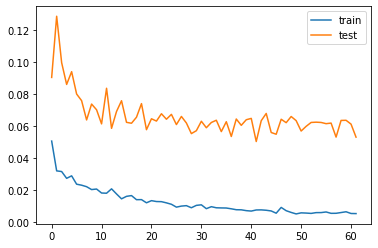

(35, 7)
(35, 7)
(35, 7)
score_train: [71.006] 48.3, 77.1, 74.0, 72.9, 45.8, 72.0, 94.6
(8, 1, 35)
score_test: [230.408] 241.1, 227.8, 245.8, 129.0, 358.3, 205.5, 117.9

RMSE test:  230.40830424974308 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0618 - val_loss: 0.0885
Epoch 2/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0304 - val_loss: 0.0775
Epoch 3/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0942
Epoch 4/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.0914
Epoch 5/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0253 - val_loss: 0.0826
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0701
Epoch 7/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.0638
Epoch 8/1000
35/35 [=============================

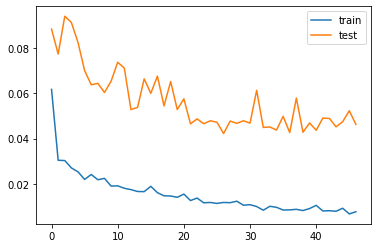

(35, 7)
(35, 7)
(35, 7)
score_train: [69.989] 64.1, 83.5, 81.1, 74.5, 64.9, 54.7, 62.3
(8, 1, 35)
score_test: [215.034] 295.5, 252.3, 175.0, 112.4, 274.0, 185.8, 140.8

RMSE test:  215.03360126314846 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0524 - val_loss: 0.0702
Epoch 2/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0862
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0265 - val_loss: 0.0922
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.0764
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0240 - val_loss: 0.0840
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0223 - val_loss: 0.0849
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0218 - val_loss: 0.0775
Epoch 8/1000
35/35 [=============================

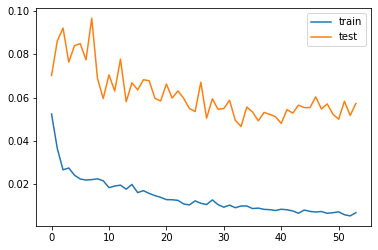

(35, 7)
(35, 7)
(35, 7)
score_train: [62.490] 68.5, 68.7, 65.8, 61.9, 63.6, 53.6, 53.5
(8, 1, 35)
score_test: [239.022] 295.0, 210.3, 288.3, 84.4, 317.9, 211.5, 180.8

RMSE test:  239.02191359129552 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 13ms/step - loss: 0.0437 - val_loss: 0.0916
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.0932
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.0958
Epoch 4/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0766
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.0905
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.1043
Epoch 7/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0657
Epoch 8/1000
35/35 [=============================

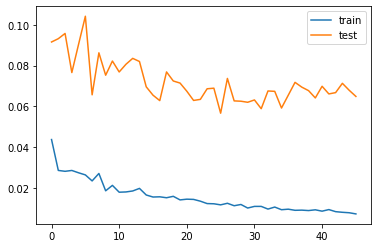

(35, 7)
(35, 7)
(35, 7)
score_train: [70.888] 68.1, 77.2, 88.4, 76.2, 62.1, 60.8, 58.4
(8, 1, 35)
score_test: [254.469] 272.7, 240.9, 243.9, 122.8, 374.4, 276.6, 172.0

RMSE test:  254.468701284571 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0447 - val_loss: 0.0737
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.0934
Epoch 3/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0294 - val_loss: 0.0906
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.1163
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.0752
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0238 - val_loss: 0.0718
Epoch 7/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0709
Epoch 8/1000
35/35 [==============================]

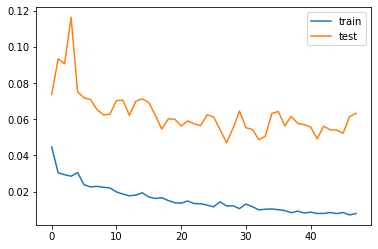

(35, 7)
(35, 7)
(35, 7)
score_train: [77.667] 66.1, 88.2, 100.1, 80.0, 80.8, 56.5, 62.8
(8, 1, 35)
score_test: [251.350] 255.0, 247.7, 414.2, 125.0, 239.7, 220.1, 150.8

RMSE test:  251.3504179047118 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0479 - val_loss: 0.0976
Epoch 2/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0336 - val_loss: 0.0877
Epoch 3/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.1072
Epoch 4/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0268 - val_loss: 0.0756
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0259 - val_loss: 0.0779
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0240 - val_loss: 0.0856
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0248 - val_loss: 0.0701
Epoch 8/1000
35/35 [=============================

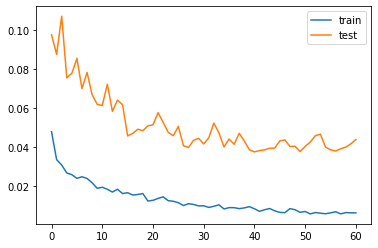

(35, 7)
(35, 7)
(35, 7)
score_train: [57.847] 53.1, 56.0, 67.1, 67.6, 53.0, 43.9, 60.4
(8, 1, 35)
score_test: [209.419] 253.0, 185.9, 269.8, 111.2, 262.9, 171.0, 158.0

RMSE test:  209.4193769139454 

8  	7     	211.687	0.75585    	209.419	211.939

Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0629 - val_loss: 0.0743
Epoch 2/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0300 - val_loss: 0.1097
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0271 - val_loss: 0.0885
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0257 - val_loss: 0.0965
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0268 - val_loss: 0.1006
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.0655
Epoch 7/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0847
Epo

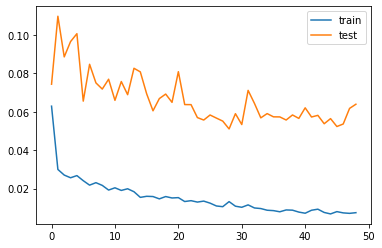

(35, 7)
(35, 7)
(35, 7)
score_train: [67.501] 56.6, 75.7, 82.8, 75.5, 63.2, 58.3, 54.9
(8, 1, 35)
score_test: [252.573] 244.5, 204.3, 323.9, 119.7, 381.7, 207.5, 192.5

RMSE test:  252.57304097388536 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0542 - val_loss: 0.0572
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.0789
Epoch 3/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0290 - val_loss: 0.0709
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.0526
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0267 - val_loss: 0.0700
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0235 - val_loss: 0.0855
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0230 - val_loss: 0.0812
Epoch 8/1000
35/35 [=============================

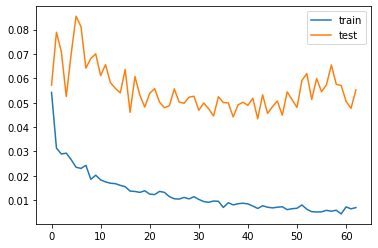

(35, 7)
(35, 7)
(35, 7)
score_train: [62.632] 56.7, 83.4, 65.1, 65.7, 53.0, 60.6, 47.5
(8, 1, 35)
score_test: [234.801] 261.9, 210.3, 304.2, 138.2, 273.2, 234.4, 178.7

RMSE test:  234.80050863702039 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0485 - val_loss: 0.0836
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.0793
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.0807
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.0902
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.0759
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0229 - val_loss: 0.0673
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0207 - val_loss: 0.0750
Epoch 8/1000
35/35 [=============================

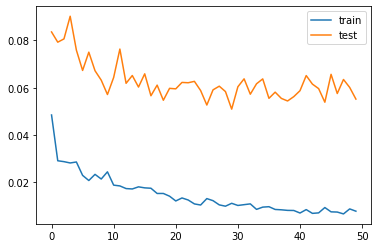

(35, 7)
(35, 7)
(35, 7)
score_train: [71.533] 82.5, 70.5, 80.8, 80.9, 54.7, 52.7, 72.2
(8, 1, 35)
score_test: [234.672] 194.4, 254.6, 289.4, 79.1, 276.1, 271.7, 206.9

RMSE test:  234.67182560482462 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0617 - val_loss: 0.1021
Epoch 2/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.1151
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.0972
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0251 - val_loss: 0.0961
Epoch 5/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0262 - val_loss: 0.1142
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0239 - val_loss: 0.0778
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0251 - val_loss: 0.0908
Epoch 8/1000
35/35 [==============================

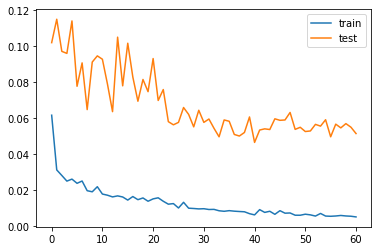

(35, 7)
(35, 7)
(35, 7)
score_train: [52.998] 50.5, 55.1, 62.6, 57.9, 48.4, 44.1, 50.1
(8, 1, 35)
score_test: [226.783] 240.4, 240.1, 215.5, 93.7, 354.3, 209.7, 140.8

RMSE test:  226.7834133935541 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0395 - val_loss: 0.0859
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0315 - val_loss: 0.0860
Epoch 3/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0264 - val_loss: 0.0656
Epoch 4/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0266 - val_loss: 0.0704
Epoch 5/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0745
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0219 - val_loss: 0.0575
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0246 - val_loss: 0.0796
Epoch 8/1000
35/35 [==============================]

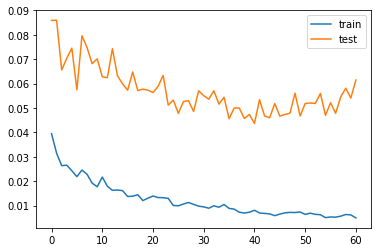

(35, 7)
(35, 7)
(35, 7)
score_train: [55.841] 46.5, 65.4, 63.4, 63.8, 43.6, 44.2, 58.7
(8, 1, 35)
score_test: [247.772] 231.0, 211.6, 358.8, 102.0, 290.9, 199.0, 261.3

RMSE test:  247.77213579792618 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0379 - val_loss: 0.0744
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0341 - val_loss: 0.1206
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0263 - val_loss: 0.0804
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0268 - val_loss: 0.1012
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.0694
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0266 - val_loss: 0.0848
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0210 - val_loss: 0.0681
Epoch 8/1000
35/35 [=============================

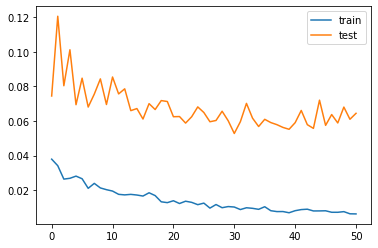

(35, 7)
(35, 7)
(35, 7)
score_train: [63.203] 59.0, 75.8, 77.2, 73.4, 52.0, 51.0, 45.6
(8, 1, 35)
score_test: [253.570] 268.7, 215.5, 379.3, 69.8, 325.6, 207.8, 182.9

RMSE test:  253.5703746473552 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0442 - val_loss: 0.0839
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.1165
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0275 - val_loss: 0.0931
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0254 - val_loss: 0.0744
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0263 - val_loss: 0.0873
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0246 - val_loss: 0.0880
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0235 - val_loss: 0.0852
Epoch 8/1000
35/35 [==============================]

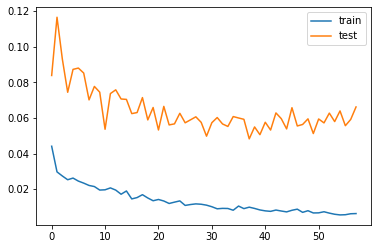

(35, 7)
(35, 7)
(35, 7)
score_train: [62.120] 55.9, 68.6, 71.8, 67.8, 53.3, 58.9, 55.9
(8, 1, 35)
score_test: [257.069] 266.7, 201.8, 356.5, 103.8, 345.0, 248.8, 178.7

RMSE test:  257.0689420360498 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0379 - val_loss: 0.0674
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.0773
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0337 - val_loss: 0.0787
Epoch 4/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0281 - val_loss: 0.0653
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0253 - val_loss: 0.0866
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0263 - val_loss: 0.0828
Epoch 7/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.0623
Epoch 8/1000
35/35 [==============================

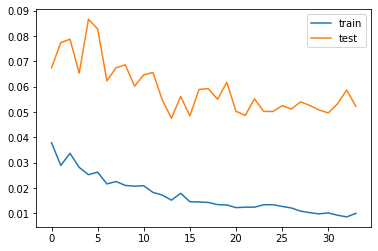

(35, 7)
(35, 7)
(35, 7)
score_train: [79.821] 90.2, 83.0, 89.4, 87.5, 67.1, 71.6, 65.6
(8, 1, 35)
score_test: [228.271] 304.8, 195.1, 266.4, 59.7, 279.9, 203.0, 199.3

RMSE test:  228.27128928787312 

9  	8     	209.923	1.0078     	209.419	211.939

Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0384 - val_loss: 0.0747
Epoch 2/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.0965
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.0950
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.0872
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0257 - val_loss: 0.0906
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0225 - val_loss: 0.0604
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0209 - val_loss: 0.0781
Epo

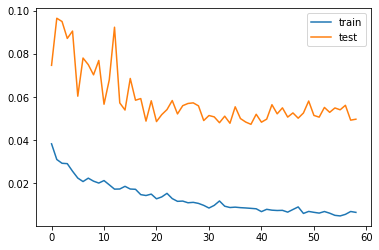

(35, 7)
(35, 7)
(35, 7)
score_train: [57.420] 50.5, 67.8, 69.1, 64.4, 54.3, 47.6, 42.4
(8, 1, 35)
score_test: [222.865] 210.2, 200.6, 287.4, 108.7, 350.1, 166.6, 135.9

RMSE test:  222.8650023310636 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0434 - val_loss: 0.0669
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.0869
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.0668
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.0726
Epoch 5/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0260 - val_loss: 0.0640
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0825
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0247 - val_loss: 0.0621
Epoch 8/1000
35/35 [==============================

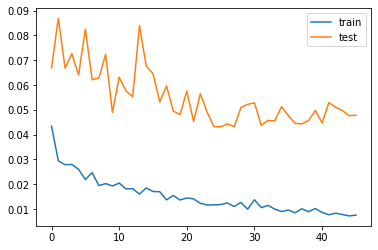

(35, 7)
(35, 7)
(35, 7)
score_train: [68.962] 63.9, 77.5, 85.0, 73.8, 60.2, 59.3, 58.4
(8, 1, 35)
score_test: [218.477] 217.7, 209.9, 200.5, 96.3, 328.9, 238.1, 168.4

RMSE test:  218.4770179066003 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0447 - val_loss: 0.0811
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.1162
Epoch 3/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.1009
Epoch 4/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0284 - val_loss: 0.0715
Epoch 5/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0260 - val_loss: 0.0934
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0233 - val_loss: 0.0774
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0236 - val_loss: 0.0601
Epoch 8/1000
35/35 [==============================]

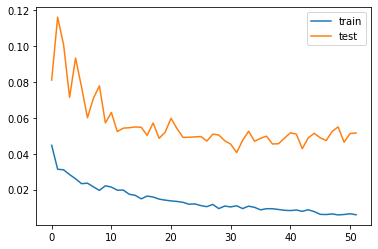

(35, 7)
(35, 7)
(35, 7)
score_train: [62.004] 64.6, 67.3, 65.7, 64.2, 50.4, 46.9, 71.0
(8, 1, 35)
score_test: [226.938] 208.3, 219.2, 316.2, 100.4, 247.8, 224.3, 217.6

RMSE test:  226.93812735206785 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0614 - val_loss: 0.0784
Epoch 2/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0314 - val_loss: 0.1147
Epoch 3/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0273 - val_loss: 0.0801
Epoch 4/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0267 - val_loss: 0.0786
Epoch 5/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0260 - val_loss: 0.0870
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0792
Epoch 7/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0215 - val_loss: 0.0751
Epoch 8/1000
35/35 [=============================

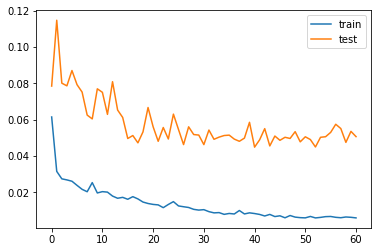

(35, 7)
(35, 7)
(35, 7)
score_train: [66.582] 51.6, 68.1, 73.6, 70.9, 72.3, 56.4, 69.9
(8, 1, 35)
score_test: [224.655] 234.0, 208.4, 250.5, 121.9, 331.0, 224.9, 131.8

RMSE test:  224.65505978273745 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0435 - val_loss: 0.0821
Epoch 2/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0288 - val_loss: 0.0875
Epoch 3/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0292 - val_loss: 0.0892
Epoch 4/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0259 - val_loss: 0.0676
Epoch 5/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.1165
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0648
Epoch 7/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0605
Epoch 8/1000
35/35 [=============================

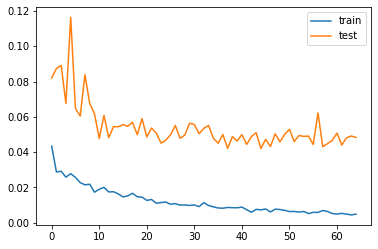

(35, 7)
(35, 7)
(35, 7)
score_train: [63.845] 56.6, 64.8, 59.4, 61.0, 47.0, 69.1, 82.9
(8, 1, 35)
score_test: [219.571] 168.8, 160.0, 242.2, 117.3, 320.6, 252.0, 211.2

RMSE test:  219.57100319849286 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 4ms/step - loss: 0.0579 - val_loss: 0.0963
Epoch 2/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0315 - val_loss: 0.1034
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.0823
Epoch 4/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.0749
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.0883
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.0897
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0252 - val_loss: 0.0815
Epoch 8/1000
35/35 [=============================

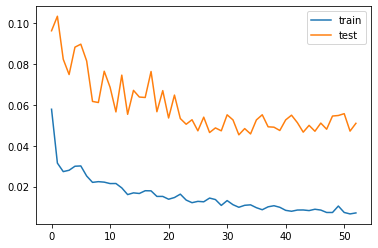

(35, 7)
(35, 7)
(35, 7)
score_train: [73.155] 63.4, 75.8, 89.0, 89.7, 70.5, 60.0, 56.1
(8, 1, 35)
score_test: [225.601] 264.5, 208.7, 216.9, 130.0, 377.0, 165.8, 95.9

RMSE test:  225.60146148577357 


Units CNN1:  255 ,Sequence size:  7
(35, 1, 35)
Epoch 1/1000
35/35 [==============================] - 0s 13ms/step - loss: 0.0650 - val_loss: 0.0949
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.1144
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.0975
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0253 - val_loss: 0.1065
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0235 - val_loss: 0.0835
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0238 - val_loss: 0.0898
Epoch 7/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.0255 - val_loss: 0.0907
Epoch 8/1000
35/35 [=============================

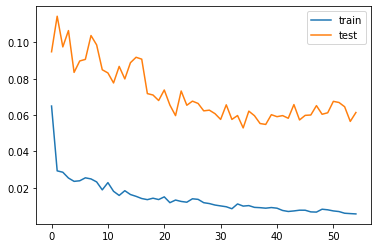

(35, 7)
(35, 7)
(35, 7)
score_train: [64.853] 61.3, 75.5, 67.5, 75.1, 61.5, 48.3, 60.7
(8, 1, 35)
score_test: [247.570] 313.8, 216.3, 290.1, 58.7, 364.3, 225.8, 111.7

RMSE test:  247.57002937420273 

10 	7     	209.419	2.84217e-14	209.419	209.419


In [79]:
population_size = 10
num_generations = 10
# 8 bits for ltsm1 , 8 for lstm 2 , 6 for sequence length , 21 for features selections
# 8 bits for cnn1 ,8 bits for cnn2 , 8 bits for lstm 2 ,8 bits for lstm 2 , 6 bits for sequence length , 21 for features selections
gene_length =14 #58

# As we are trying to minimize the RMSE score, that's why using -1.0. 
# In case, when you want to maximize accuracy for instance, use 1.0
creator.create('FitnessMax', base.Fitness, weights = (-1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.9)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.7)
toolbox.register('select', tools.selRoulette)
toolbox.register('evaluate', train_evaluate)
population = toolbox.population(n = population_size)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
#param cxpb: The probability of mating two individuals.
#param mutpb: The probability of mutating an individual.
population , logbook  = algorithms.eaSimple(population, toolbox,halloffame=hof, cxpb = 0.7, mutpb = 0.6,stats=stats, ngen = num_generations, verbose = True)

In [80]:
print('Best score :', best_score)

Best score : 209.4193769139454


In [81]:
model=model_name
model.summary()

Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_71 (Conv1D)           (None, 1, 255)            18105     
_________________________________________________________________
flatten_71 (Flatten)         (None, 255)               0         
_________________________________________________________________
dropout_71 (Dropout)         (None, 255)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 7)                 1792      
Total params: 19,897
Trainable params: 19,897
Non-trainable params: 0
_________________________________________________________________


In [82]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# make a prediction
yhat = model.predict(X_test[[0,7]])
yhat.shape 

(2, 7)

In [83]:
yhat = yhat.reshape(-1, yhat.shape[-1])

In [84]:
#yhat

In [85]:
# invert scaling for forecast
y_test_pred = scaler2.inverse_transform(yhat)
#print(inv_yhat)
# invert scaling for actual
Y_test_true =Y_test[[0,7]]
Y_test_true = Y_test_true.reshape(-1, Y_test_true.shape[-1])
y_test_true= scaler2.inverse_transform(Y_test_true)
#print(inv_y)

In [86]:
days

DatetimeIndex(['2020-08-02', '2020-08-03', '2020-08-04', '2020-08-05',
               '2020-08-06', '2020-08-07', '2020-08-08', '2020-08-09',
               '2020-08-10', '2020-08-11', '2020-08-12', '2020-08-13',
               '2020-08-14', '2020-08-15'],
              dtype='datetime64[ns]', name='timestamp', freq=None)

In [87]:
test_res=pd.DataFrame()
test_res['Prediction']=y_test_pred.flatten()[0:14]
test_res['real']=y_test_true.flatten()[0:14]
test_res.set_index(days,inplace=True)

In [88]:
test_res

,Prediction,real
timestamp,,
2020-08-02,827.348328,693.0
2020-08-03,720.907104,522.0
2020-08-04,782.900146,659.0
2020-08-05,901.304626,1021.0
2020-08-06,942.606812,1283.0
2020-08-07,913.699829,1144.0
2020-08-08,795.582825,1018.0
2020-08-09,1013.382629,1345.0
2020-08-10,1058.179688,1230.0


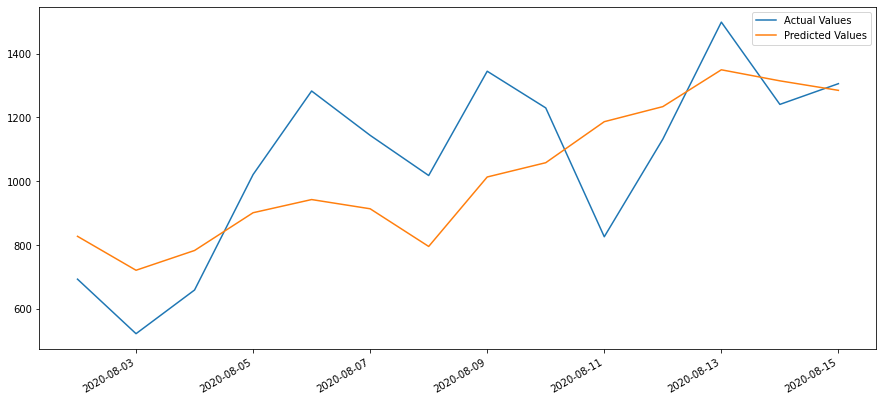

In [89]:

import pandas as pd
import numpy as np; np.random.seed(1)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,7))
plt.plot(test_res.index, test_res['real'],  label='Actual Values')
plt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')
# If you don't like the break in the graph, change 90 to 89 in the above line
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()




In [90]:
import numpy as np 
from sklearn import metrics
print('Test Metrics')
print('MSE:', round(metrics.mean_squared_error(test_res['real'], test_res['Prediction']), 2))
print('RMSE:',round( np.sqrt(metrics.mean_squared_error(test_res['real'], test_res['Prediction'])), 2))
print('MAE:', round(metrics.mean_absolute_error(test_res['real'], test_res['Prediction']), 2))
print('R Squared:', round( metrics.r2_score(test_res['real'], test_res['Prediction']), 2))
print('Max Error:',round(  metrics.max_error(test_res['real'], test_res['Prediction']), 2))


Test Metrics
MSE: 43856.48
RMSE: 209.42
MAE: 184.32
R Squared: 0.44
Max Error: 360.81


In [91]:
# make a prediction
y_train_pred = model.predict(X_train)
y_train_pred .shape

(35, 7)

In [92]:
y_train_pred = y_train_pred.reshape(y_train_pred.shape[0], y_train_pred.shape[1])
y_train_pred.shape

(35, 7)

In [93]:

# invert scaling for forecast

y_train_pred = scaler2.inverse_transform(y_train_pred)
Y_train_true = Y_train.reshape((len(Y_train), n_out))

y_train_real = scaler2.inverse_transform(Y_train_true )

In [94]:

# Flatten for final errors
Y_train_pred_bis = y_train_pred.flatten()
Y_train_real_bis = y_train_real.flatten()

In [95]:
y_train_pred[0]

array([ 701.906  ,  680.8792 ,  550.71576, 1031.7096 ,  872.5735 ,
        768.6843 ,  699.65375], dtype=float32)

In [96]:
#For plot 
#filter_indices = [0,7,14,21,28,35,42,49,56,63,70,77,84,91,98,105]
filter_indices = [0,7,14,21,28]
y_train_pred = y_train_pred [filter_indices ]

In [97]:
# Part of train dataset
y_train_real= y_train_real[filter_indices]
Y_train_pred = y_train_pred.flatten()
Y_train_real = y_train_real.flatten()

In [98]:
mask = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))
date_train = df.loc[mask].date.sort_index(axis = 0) 
X_train.shape

(35, 1, 35)

In [99]:
date_train.head(7)

23033   2020-06-15
23034   2020-06-16
23035   2020-06-17
23036   2020-06-18
23037   2020-06-19
23038   2020-06-20
23039   2020-06-21
Name: date, dtype: datetime64[ns]

In [100]:
taille_x = date_train.shape[0] - nb_seq
taille_x 

41

In [101]:
date_train = date_train.values.flatten()

In [102]:
prediction_train = pd.DataFrame(columns=['date_to_prediction','true_value','predict'])

In [103]:
Y_train_pred.shape

(35,)

In [104]:
Y_train_real.shape

(35,)

In [105]:
date_train.shape

(48,)

In [106]:
date_train[nb_seq:].shape

(41,)

In [107]:
suite_size = Y_train_real.shape[0]- date_train[nb_seq:].shape[0]
suite_size 

-6

In [108]:
Y_train_real[:-suite_size].shape

(6,)

In [109]:
date_train[nb_seq:].shape

(41,)

In [110]:
Y_train_pred[:-suite_size].shape

(6,)

In [111]:
Y_train_real[:-suite_size].shape

(6,)

In [112]:
date_trainX = date_train[nb_seq:]

In [113]:
date_trainX[0:Y_train_pred.shape[0]].shape

(35,)

In [114]:
prediction_train['date_to_prediction'] = date_trainX[0:Y_train_pred.shape[0]]
prediction_train['predict'] = Y_train_pred
prediction_train['true_value'] = Y_train_real


In [115]:
prediction_train['date_to_prediction'] = pd.to_datetime(prediction_train['date_to_prediction'], infer_datetime_format=True)

In [116]:
prediction_train.set_index('date_to_prediction',inplace=True)

In [117]:
prediction_train.head(20)

,true_value,predict
date_to_prediction,,
2020-06-22,665.403564,701.906006
2020-06-23,683.259644,680.879211
2020-06-24,586.460938,550.715759
2020-06-25,1104.286987,1031.709595
2020-06-26,905.050781,872.573486
2020-06-27,777.238892,768.684326
2020-06-28,729.309509,699.653748
2020-06-29,664.463745,657.721436
2020-06-30,723.670776,729.854980


In [118]:
prediction_train.tail(10)

,true_value,predict
date_to_prediction,,
2020-07-17,652.246521,638.185547
2020-07-18,783.817505,738.439026
2020-07-19,771.600159,705.976501
2020-07-20,707.694214,810.412659
2020-07-21,806.372498,801.817810
2020-07-22,669.162781,801.501465
2020-07-23,706.754517,775.453918
2020-07-24,783.817505,788.939087
2020-07-25,1035.682007,1018.443237


"\nfig, ax = plt.subplots(figsize=(15,7))\nplt.plot(test_res.index, test_res['real'],  label='Actual Values')\nplt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')\n# If you don't like the break in the graph, change 90 to 89 in the above line\nplt.gcf().autofmt_xdate()\nplt.legend()\nplt.show()\n"

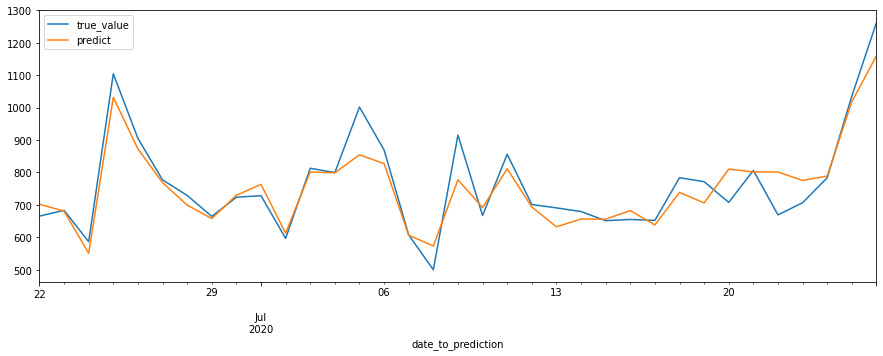

In [119]:
# Prédiction du train vs la réalité 
prediction_train.plot(figsize=(15,5))
'''
fig, ax = plt.subplots(figsize=(15,7))
plt.plot(test_res.index, test_res['real'],  label='Actual Values')
plt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')
# If you don't like the break in the graph, change 90 to 89 in the above line
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()
'''

In [120]:
print('Trains Metrics')
loss = tf.keras.losses.mean_squared_error(Y_train_real_bis, Y_train_pred_bis )
print('MSE',"{:.2f}".format(loss))
rmse = tf.sqrt(tf.losses.mean_squared_error(Y_train_real_bis, Y_train_pred_bis ))
print('RMSE',"{:.2f}".format(rmse))
loss2 = tf.keras.losses.MAE(Y_train_real_bis, Y_train_pred_bis )
print('MAE',"{:.2f}".format(loss2))
r2 =r2_score(Y_train_real_bis, Y_train_pred_bis )
print('R2',"{:.2f}".format(r2))
maxerror=max_error(Y_train_real_bis, Y_train_pred_bis )
print('maxError',"{:.2f}".format(maxerror))

Trains Metrics
MSE 3346.22
RMSE 57.85
MAE 42.30
R2 0.90
maxError 192.63
